# Homework 03: Learning Curves and Training Workflow

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

In this homework, you will use **early stopping** to select the "best" model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance. Test accuracy is reported for reference but is not used for model selection.

> **Note:** Throughout this homework, best always refers to the model selected by early stopping at the epoch of minimum validation loss. Do not report metrics from the final training epoch unless explicitly instructed.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework. 

In [1]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


In [2]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [3]:
def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training. 

In [4]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the dataset and extract a stratified subset

This data set is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced. 

In [5]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
x, y = fetch_covtype(return_X_y=True)  # y in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set. 


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {np.int32(2): 1000, np.int32(0): 1000, np.int32(4): 1000, np.int32(5): 1000, np.int32(1): 1000, np.int32(3): 1000, np.int32(6): 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={np.int32(2): 600, np.int32(1): 600, np.int32(0): 600, np.int32(3): 600, np.int32(5): 600, np.int32(4): 600, np.int32(6): 600}
val  : total=1400, per-class={np.int32(1): 200, np.int32(6): 200, np.int32(5): 200, np.int32(4): 200, np.int32(3): 200, np.int32(2): 200, np.int32(0): 200}
test : total=1400, per-class={np.int32(0): 200, np.int32(6): 200, np.int32(2): 200, np.int32(3): 200, np.int32(4): 200, np.int32(5): 200, np.int32(1): 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters. 

In [6]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained. 

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [ ]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),                              
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

**We call `build_model` as shown here:**

In [ ]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



P1: relu model



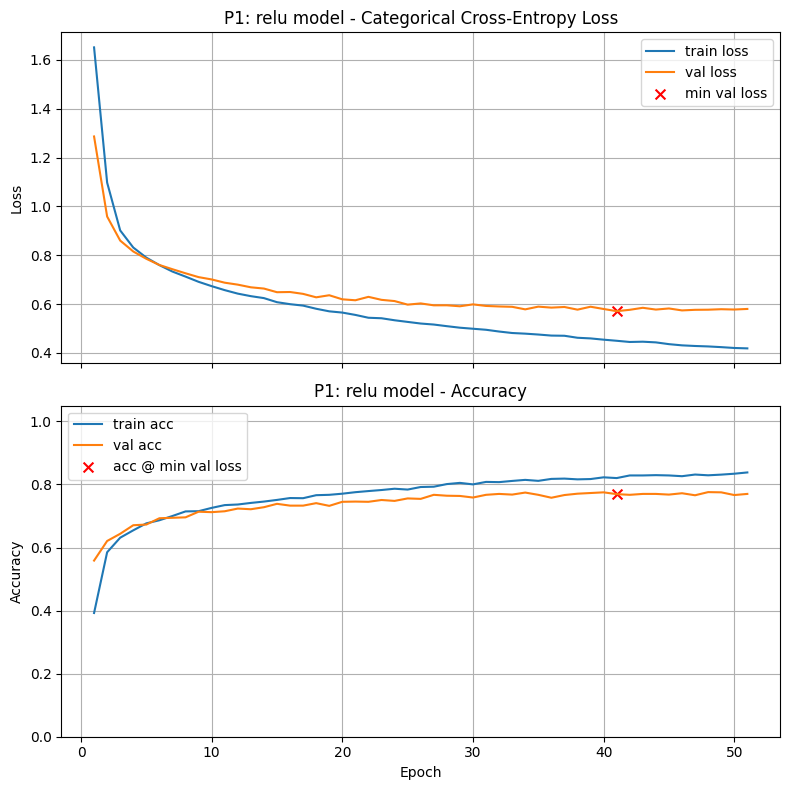

Final Training Loss:            0.4184
Final Training Accuracy:        0.8381
Final Validation Loss:          0.5799
Final Validation Accuracy:      0.7700
Minimum Validation Loss:        0.5708 (Epoch 41)
Validation Accuracy @ Min Loss: 0.7693

Test Loss: 0.6000
Test Accuracy: 0.7543

Validation-Test Gap (accuracy): 0.015000

Execution Time: 00:00:02

P1: sigmoid model



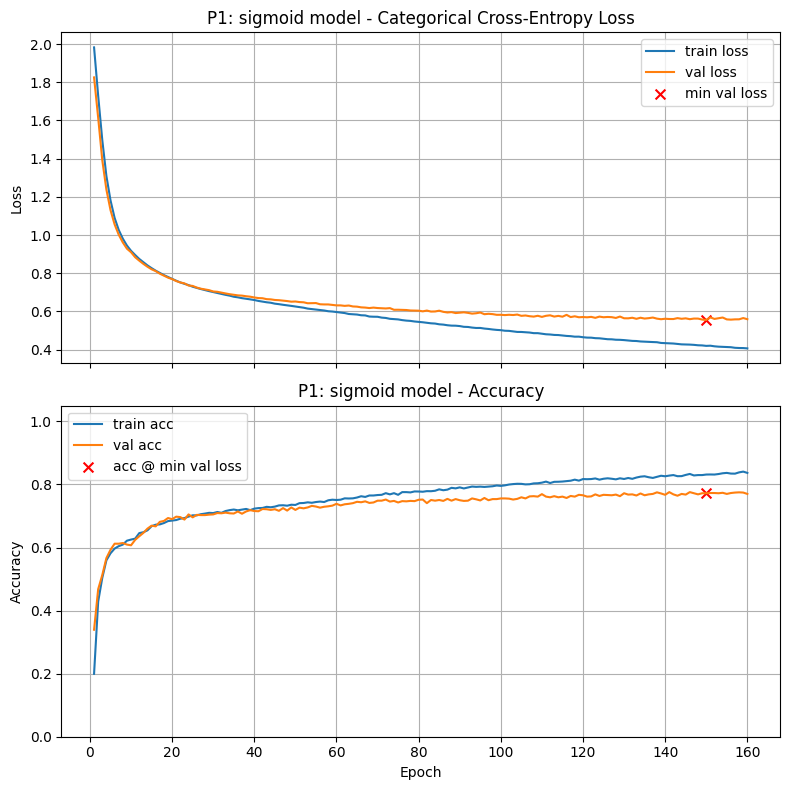

Final Training Loss:            0.4067
Final Training Accuracy:        0.8367
Final Validation Loss:          0.5594
Final Validation Accuracy:      0.7700
Minimum Validation Loss:        0.5556 (Epoch 150)
Validation Accuracy @ Min Loss: 0.7721

Test Loss: 0.5714
Test Accuracy: 0.7736

Validation-Test Gap (accuracy): 0.001429

Execution Time: 00:00:07

P1: tanh model



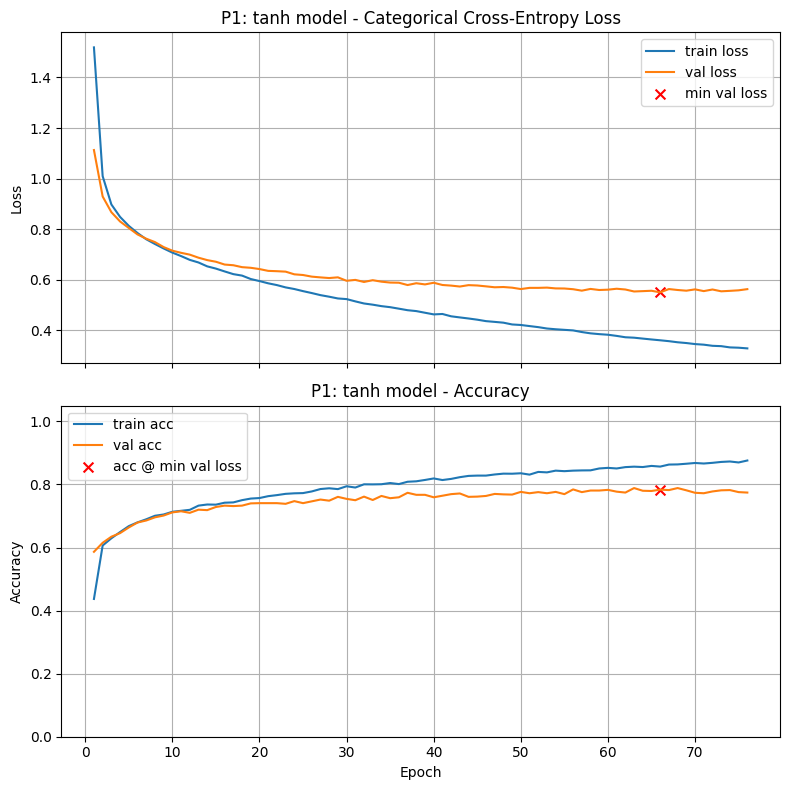

Final Training Loss:            0.3289
Final Training Accuracy:        0.8760
Final Validation Loss:          0.5631
Final Validation Accuracy:      0.7743
Minimum Validation Loss:        0.5504 (Epoch 66)
Validation Accuracy @ Min Loss: 0.7836

Test Loss: 0.5518
Test Accuracy: 0.7743

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:04
P1: tanh model                          	0.7836
P1: sigmoid model                       	0.7721
P1: relu model                          	0.7693


In [ ]:
# Your code here. Add as many cells as you need. 
activation_functions = ["relu", "sigmoid", "tanh"]
for activation_function in activation_functions:
    tanh_model_with_LR = build_model(X_train.shape[1], [ (64,activation_function,0.0,0.0), (32,activation_function,0.0,0.0)], n_classes)
    train_and_test(tanh_model_with_LR, title=f"P1: {activation_function} model")

print_results()

### Graded Questions

In [9]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 2             # Replace with integer 0 (relu), 1 (sigmoid), or 2 (tanh)

In [10]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a}') 


a1a = 2


In [11]:
# Set a1b to the validation accuracy found by this best activation function

a1b = results.get("P1: tanh model")[0]             # Replace 0.0 with your answer

In [12]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}') 

a1b = 0.7836


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**



P2: tanh model with 0.001 learning rate



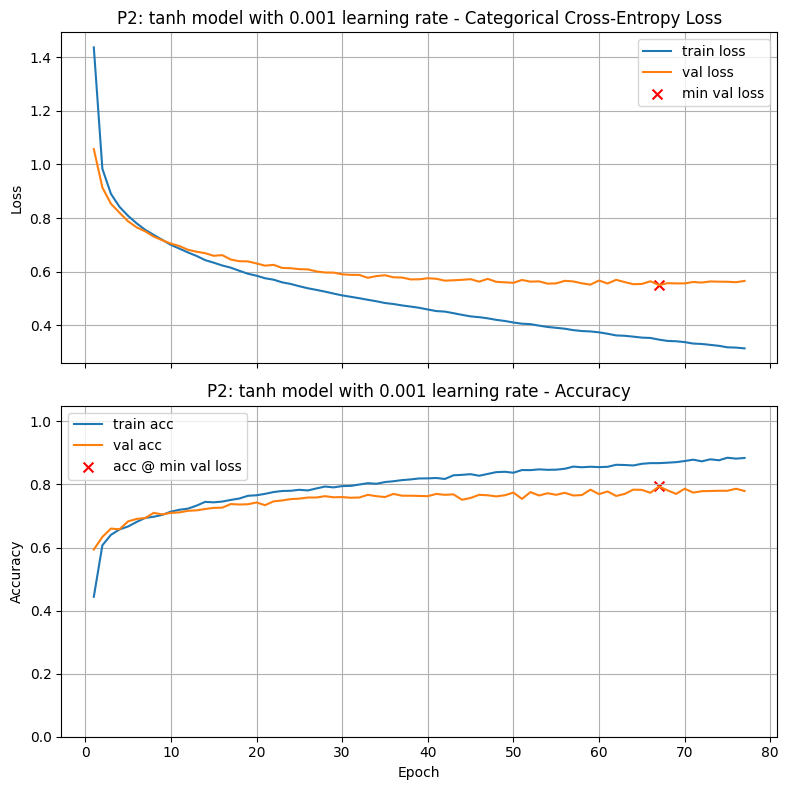

Final Training Loss:            0.3144
Final Training Accuracy:        0.8840
Final Validation Loss:          0.5658
Final Validation Accuracy:      0.7793
Minimum Validation Loss:        0.5503 (Epoch 67)
Validation Accuracy @ Min Loss: 0.7936

Test Loss: 0.5665
Test Accuracy: 0.7636

Validation-Test Gap (accuracy): 0.030000

Execution Time: 00:00:04

P2: tanh model with 0.0005 learning rate



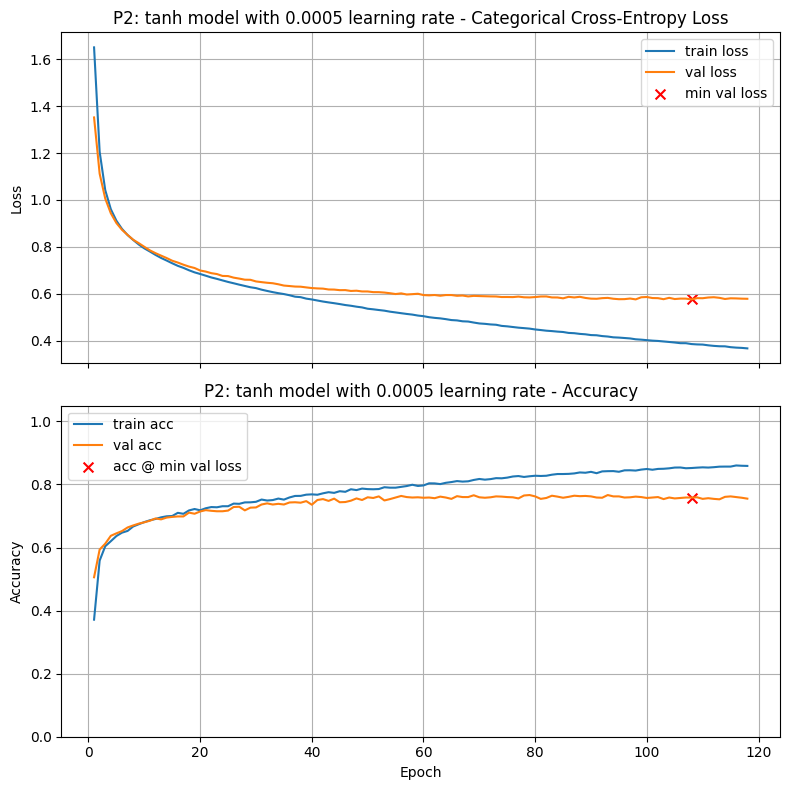

Final Training Loss:            0.3672
Final Training Accuracy:        0.8588
Final Validation Loss:          0.5786
Final Validation Accuracy:      0.7550
Minimum Validation Loss:        0.5759 (Epoch 108)
Validation Accuracy @ Min Loss: 0.7586

Test Loss: 0.5775
Test Accuracy: 0.7657

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:06

P2: tanh model with 0.0001 learning rate



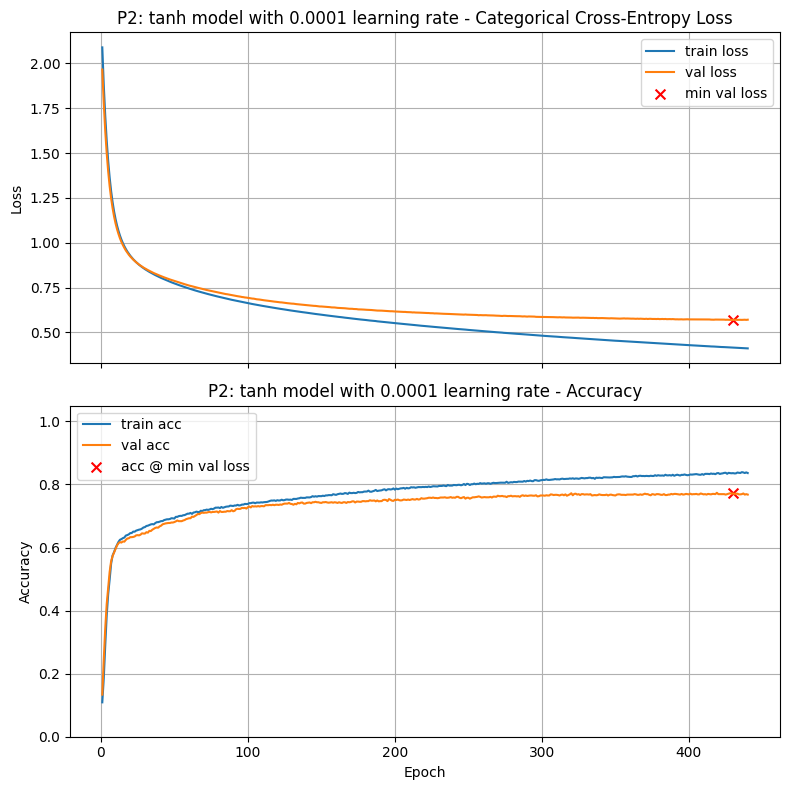

Final Training Loss:            0.4113
Final Training Accuracy:        0.8362
Final Validation Loss:          0.5712
Final Validation Accuracy:      0.7679
Minimum Validation Loss:        0.5698 (Epoch 430)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.5843
Test Accuracy: 0.7493

Validation-Test Gap (accuracy): 0.022143

Execution Time: 00:00:20

P2: tanh model with 5e-05 learning rate



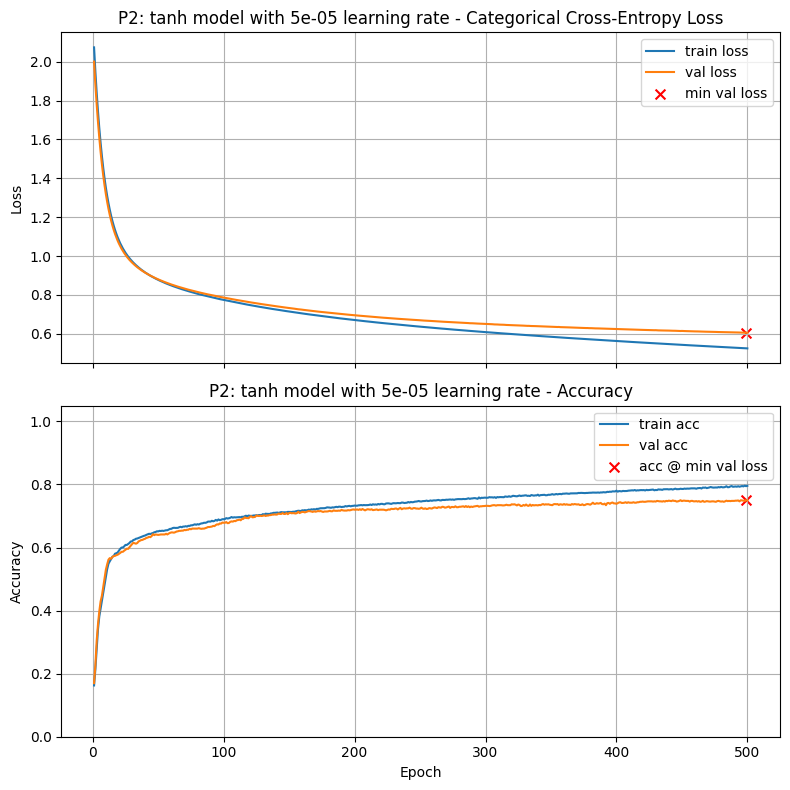

Final Training Loss:            0.5252
Final Training Accuracy:        0.7957
Final Validation Loss:          0.6058
Final Validation Accuracy:      0.7493
Minimum Validation Loss:        0.6058 (Epoch 499)
Validation Accuracy @ Min Loss: 0.7500

Test Loss: 0.6183
Test Accuracy: 0.7443

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:00:23

P2: tanh model with 1e-05 learning rate



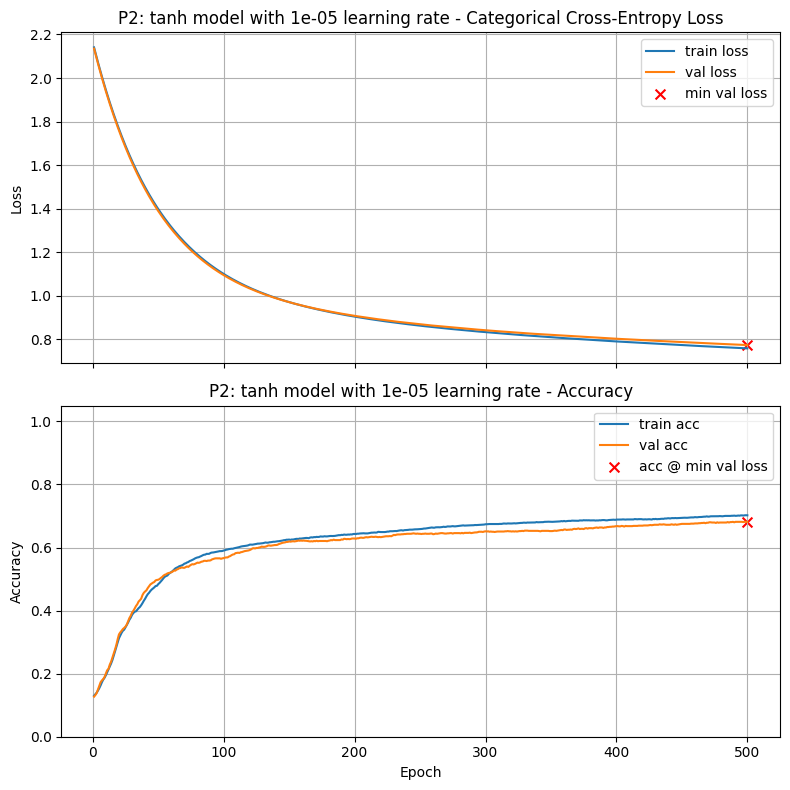

Final Training Loss:            0.7582
Final Training Accuracy:        0.7021
Final Validation Loss:          0.7735
Final Validation Accuracy:      0.6814
Minimum Validation Loss:        0.7735 (Epoch 500)
Validation Accuracy @ Min Loss: 0.6814

Test Loss: 0.7832
Test Accuracy: 0.6929

Validation-Test Gap (accuracy): 0.011429

Execution Time: 00:00:23
P2: tanh model with 0.001 learning rate 	0.7936
P1: tanh model                          	0.7836
P1: sigmoid model                       	0.7721
P2: tanh model with 0.0001 learning rate	0.7714
P1: relu model                          	0.7693
P2: tanh model with 0.0005 learning rate	0.7586
P2: tanh model with 5e-05 learning rate 	0.7500
P2: tanh model with 1e-05 learning rate 	0.6814


In [13]:
# Your code here. Add as many cells as you need. 
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
for learning_rate in learning_rates:
    tanh_model_with_LR = build_model(X_train.shape[1], [ (64,'tanh',0.0,0.0), (32,'tanh',0.0,0.0)], n_classes)
    train_and_test(tanh_model_with_LR, lr_schedule=learning_rate, title=f"P2: tanh model with {learning_rate} learning rate")

print_results()

#### Graded Questions

In [14]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 0.001           # Replace 0.0 with your answer

In [15]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.6f}') 

a2a = 0.001000


In [16]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = results.get("P2: tanh model with 0.001 learning rate")[0]             # Replace 0.0 with your answer

In [17]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7936


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



P3: tanh model with 0.0 and 0.3 dropout



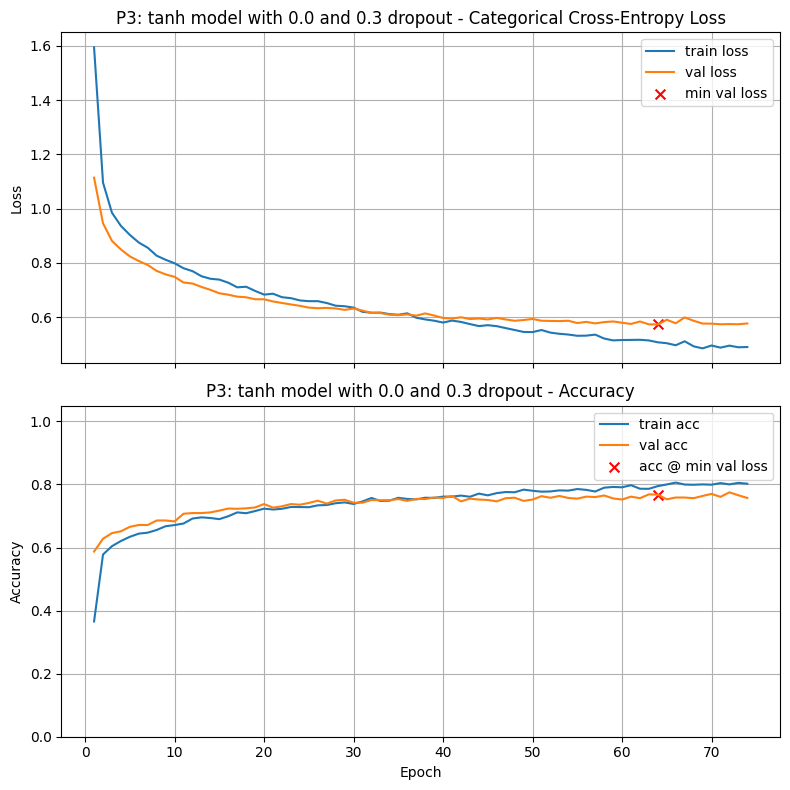

Final Training Loss:            0.4901
Final Training Accuracy:        0.8024
Final Validation Loss:          0.5769
Final Validation Accuracy:      0.7571
Minimum Validation Loss:        0.5733 (Epoch 64)
Validation Accuracy @ Min Loss: 0.7679

Test Loss: 0.5981
Test Accuracy: 0.7529

Validation-Test Gap (accuracy): 0.015000

Execution Time: 00:00:04

P3: tanh model with 0.0 and 0.4 dropout



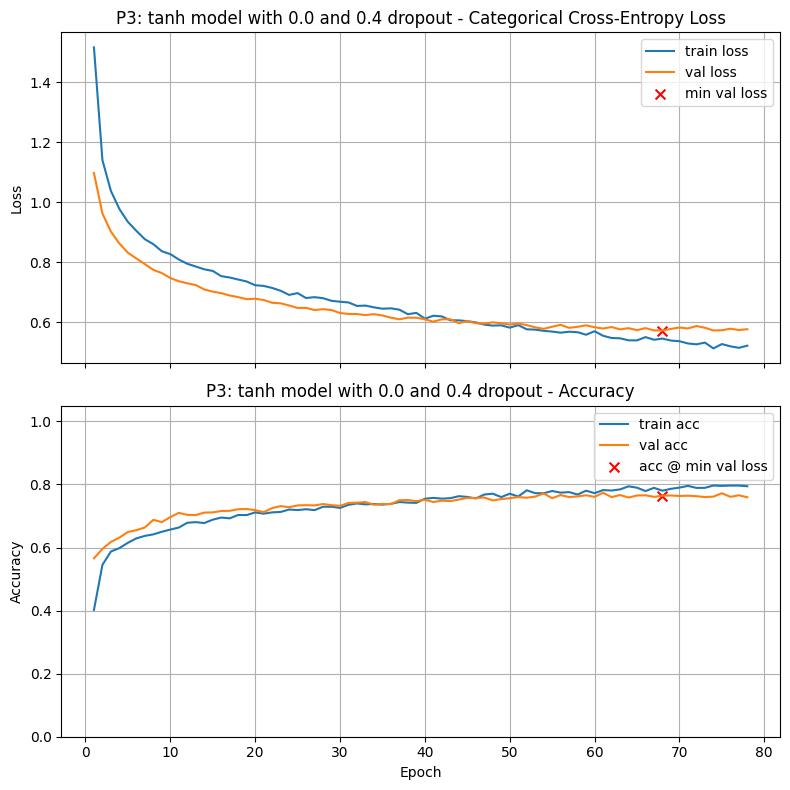

Final Training Loss:            0.5216
Final Training Accuracy:        0.7943
Final Validation Loss:          0.5765
Final Validation Accuracy:      0.7593
Minimum Validation Loss:        0.5721 (Epoch 68)
Validation Accuracy @ Min Loss: 0.7643

Test Loss: 0.6149
Test Accuracy: 0.7557

Validation-Test Gap (accuracy): 0.008571

Execution Time: 00:00:04

P3: tanh model with 0.0 and 0.5 dropout



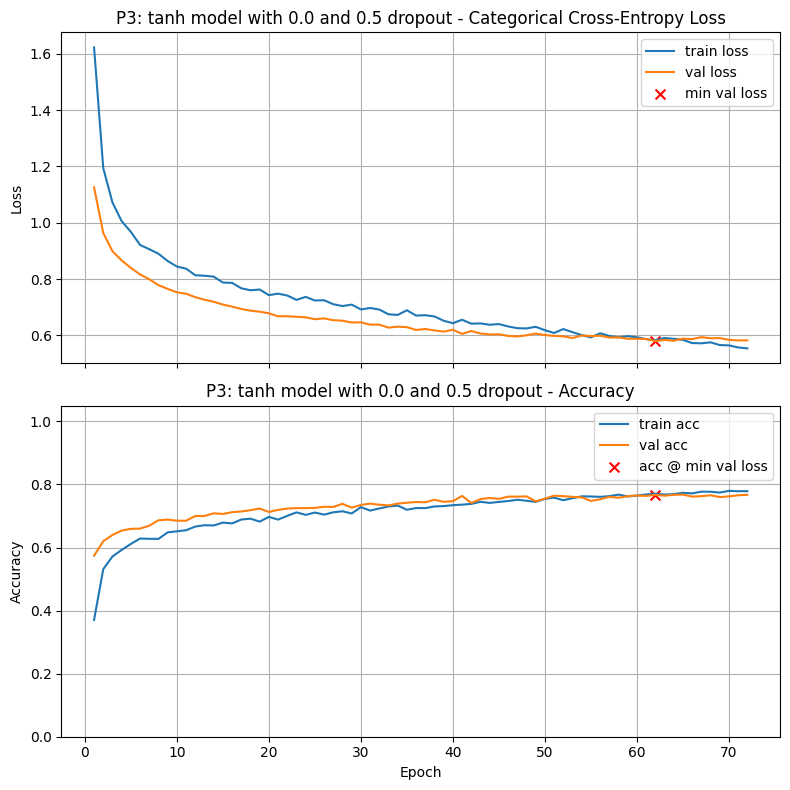

Final Training Loss:            0.5541
Final Training Accuracy:        0.7788
Final Validation Loss:          0.5826
Final Validation Accuracy:      0.7671
Minimum Validation Loss:        0.5802 (Epoch 62)
Validation Accuracy @ Min Loss: 0.7671

Test Loss: 0.6215
Test Accuracy: 0.7636

Validation-Test Gap (accuracy): 0.003571

Execution Time: 00:00:03

P3: tanh model with 0.1 and 0.3 dropout



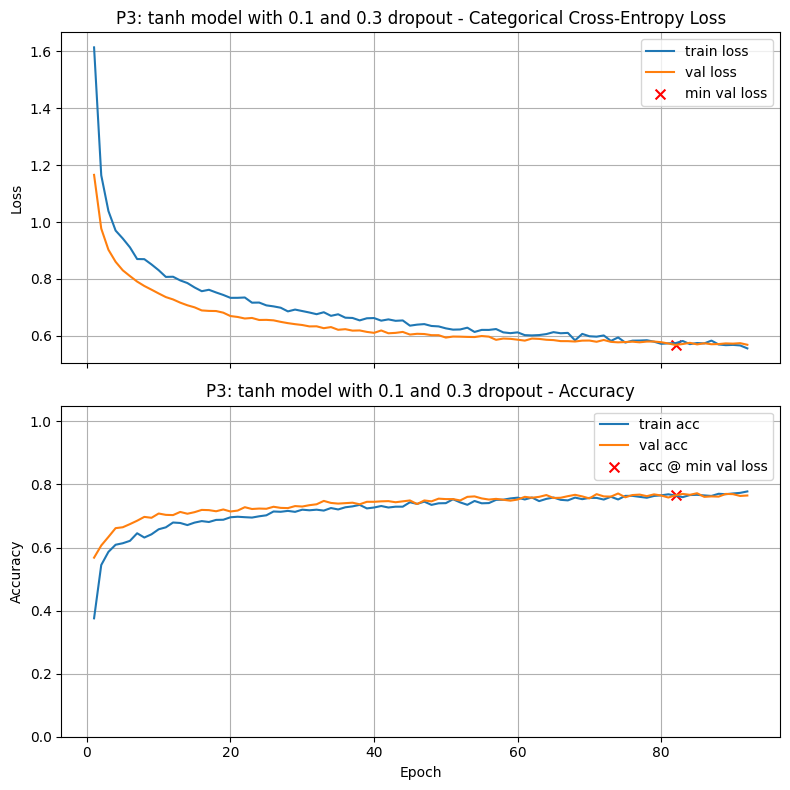

Final Training Loss:            0.5557
Final Training Accuracy:        0.7779
Final Validation Loss:          0.5684
Final Validation Accuracy:      0.7650
Minimum Validation Loss:        0.5678 (Epoch 82)
Validation Accuracy @ Min Loss: 0.7657

Test Loss: 0.5988
Test Accuracy: 0.7479

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:04

P3: tanh model with 0.1 and 0.4 dropout



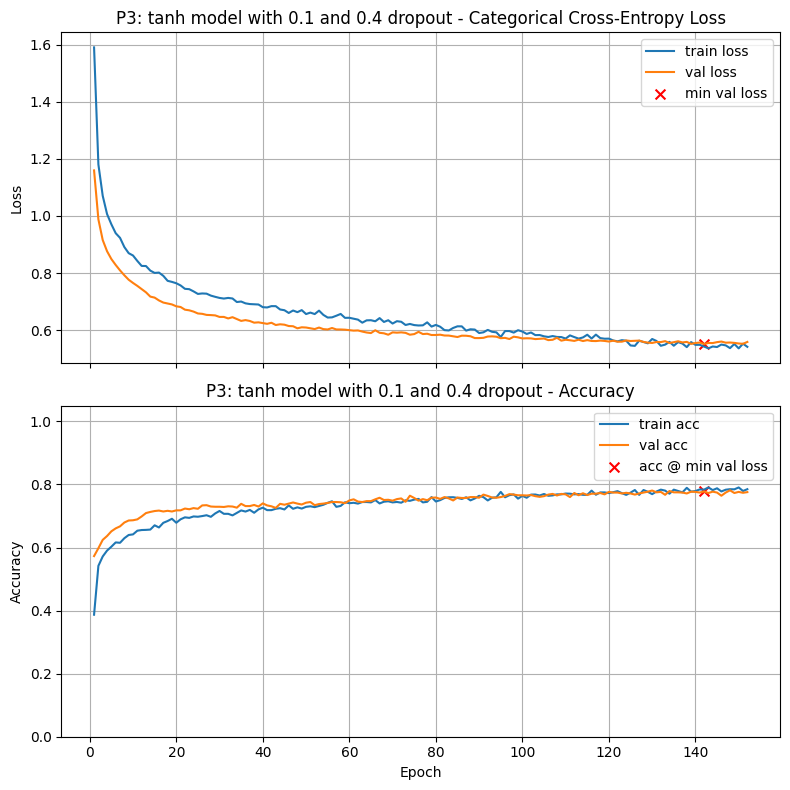

Final Training Loss:            0.5420
Final Training Accuracy:        0.7850
Final Validation Loss:          0.5590
Final Validation Accuracy:      0.7757
Minimum Validation Loss:        0.5518 (Epoch 142)
Validation Accuracy @ Min Loss: 0.7779

Test Loss: 0.5804
Test Accuracy: 0.7764

Validation-Test Gap (accuracy): 0.001429

Execution Time: 00:00:07

P3: tanh model with 0.1 and 0.5 dropout



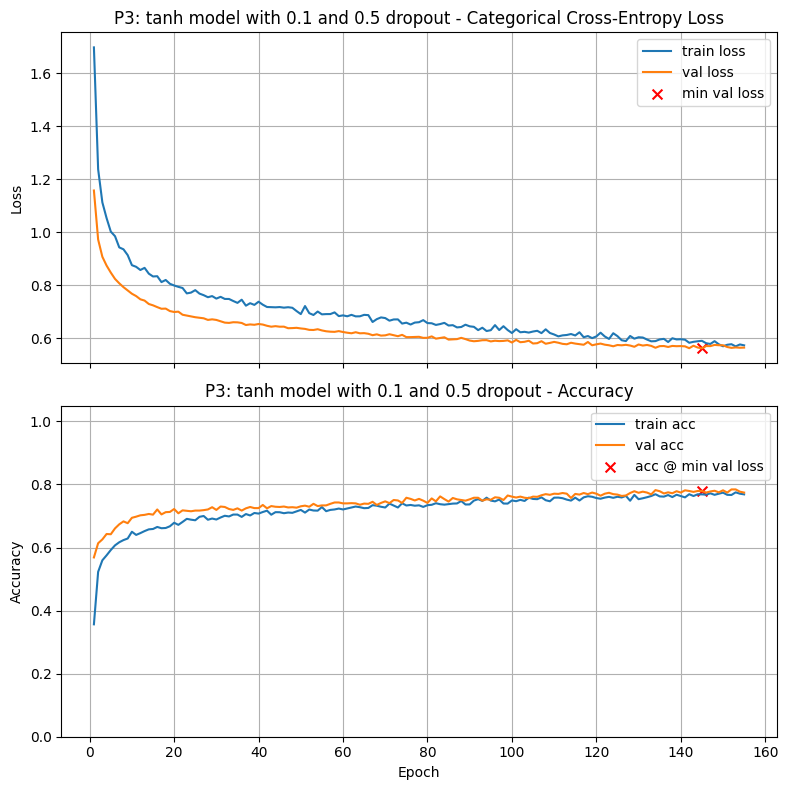

Final Training Loss:            0.5730
Final Training Accuracy:        0.7686
Final Validation Loss:          0.5645
Final Validation Accuracy:      0.7743
Minimum Validation Loss:        0.5616 (Epoch 145)
Validation Accuracy @ Min Loss: 0.7793

Test Loss: 0.5854
Test Accuracy: 0.7564

Validation-Test Gap (accuracy): 0.022857

Execution Time: 00:00:07

P3: tanh model with 0.2 and 0.3 dropout



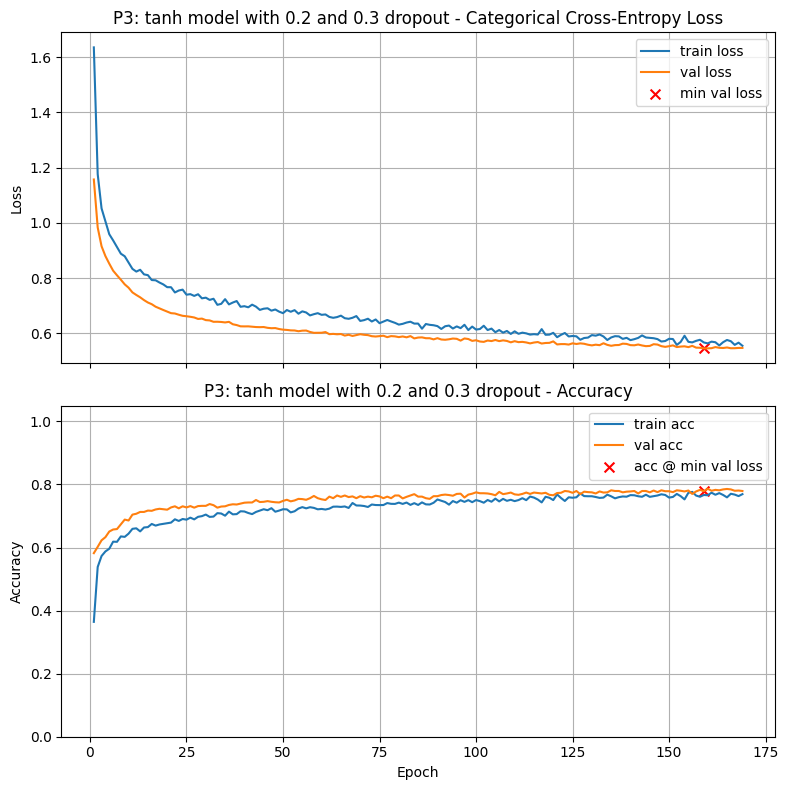

Final Training Loss:            0.5552
Final Training Accuracy:        0.7693
Final Validation Loss:          0.5475
Final Validation Accuracy:      0.7793
Minimum Validation Loss:        0.5458 (Epoch 159)
Validation Accuracy @ Min Loss: 0.7786

Test Loss: 0.5873
Test Accuracy: 0.7643

Validation-Test Gap (accuracy): 0.014286

Execution Time: 00:00:08

P3: tanh model with 0.2 and 0.4 dropout



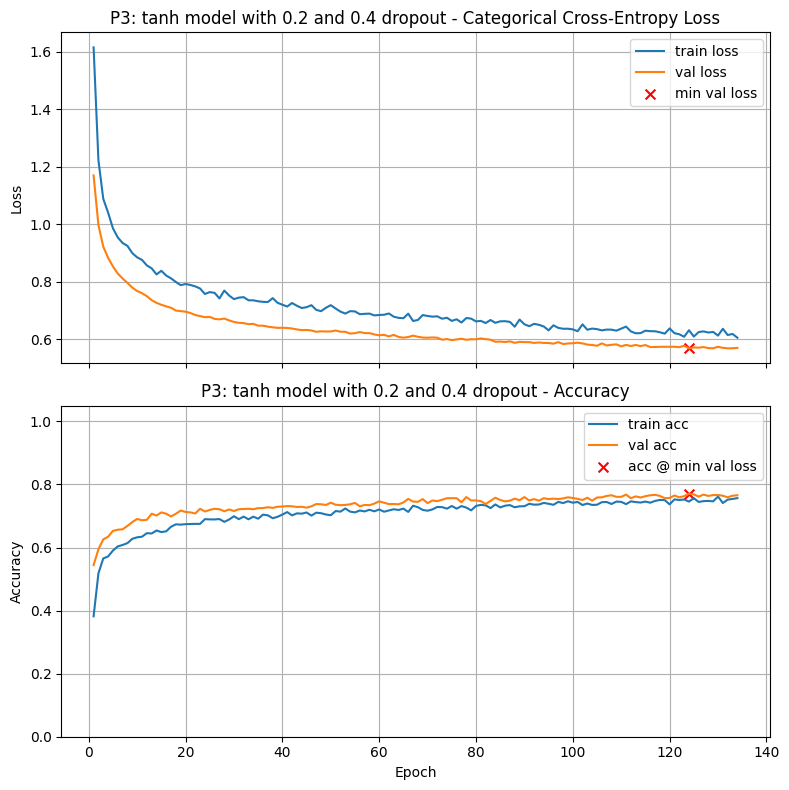

Final Training Loss:            0.6058
Final Training Accuracy:        0.7567
Final Validation Loss:          0.5704
Final Validation Accuracy:      0.7657
Minimum Validation Loss:        0.5687 (Epoch 124)
Validation Accuracy @ Min Loss: 0.7707

Test Loss: 0.5993
Test Accuracy: 0.7493

Validation-Test Gap (accuracy): 0.021429

Execution Time: 00:00:06

P3: tanh model with 0.2 and 0.5 dropout



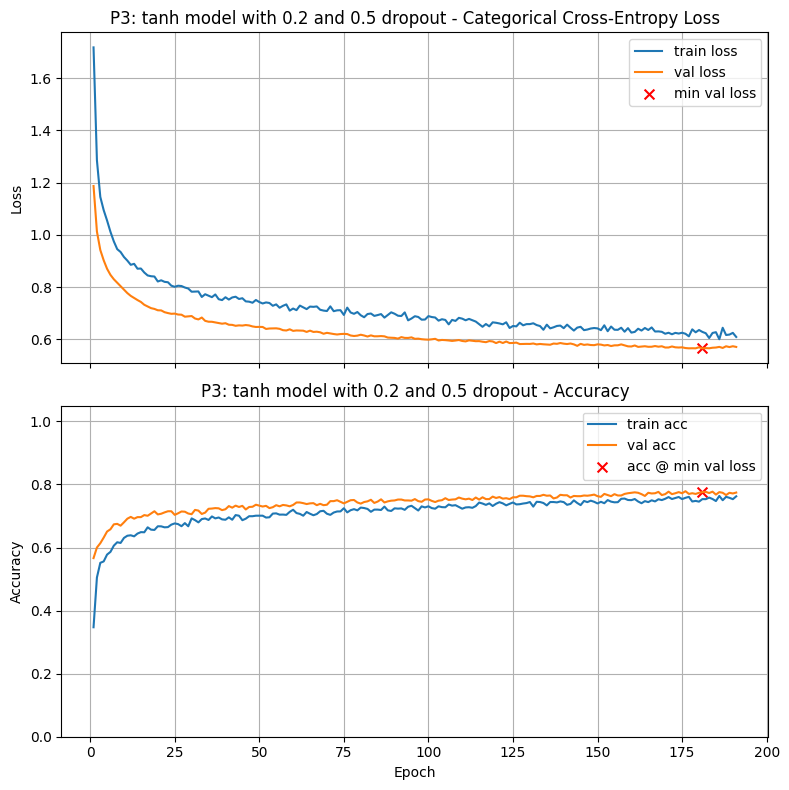

Final Training Loss:            0.6088
Final Training Accuracy:        0.7624
Final Validation Loss:          0.5706
Final Validation Accuracy:      0.7743
Minimum Validation Loss:        0.5651 (Epoch 181)
Validation Accuracy @ Min Loss: 0.7757

Test Loss: 0.6000
Test Accuracy: 0.7614

Validation-Test Gap (accuracy): 0.014286

Execution Time: 00:00:09
P2: tanh model with 0.001 learning rate 	0.7936
P1: tanh model                          	0.7836
P3: tanh model with 0.1 and 0.5 dropout 	0.7793
P3: tanh model with 0.2 and 0.3 dropout 	0.7786
P3: tanh model with 0.1 and 0.4 dropout 	0.7779
P3: tanh model with 0.2 and 0.5 dropout 	0.7757
P1: sigmoid model                       	0.7721
P2: tanh model with 0.0001 learning rate	0.7714
P3: tanh model with 0.2 and 0.4 dropout 	0.7707
P1: relu model                          	0.7693
P3: tanh model with 0.0 and 0.3 dropout 	0.7679
P3: tanh model with 0.0 and 0.5 dropout 	0.7671
P3: tanh model with 0.1 and 0.3 dropout 	0.7657
P3: tanh model with 0

In [18]:
# Your code here. Add as many cells as you need. 
dropout_first_hidden_layers = [0.0, 0.1, 0.2]
dropout_second_hidden_layers = [0.3, 0.4, 0.5]
for dropout_first in dropout_first_hidden_layers:
    for dropout_second in dropout_second_hidden_layers:
        model_with_dropout = build_model(X_train.shape[1], [ (64,'tanh',0.0,dropout_first), (32,'tanh',0.0,dropout_second) ], n_classes)
        train_and_test(model_with_dropout, lr_schedule=0.001, title=f"P3: tanh model with {dropout_first} and {dropout_second} dropout")

print_results()

In [19]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a3a = (0.1,0.5)             # Replace (0.0,0.0) with your answer

In [20]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a}') 

a3a = (0.1, 0.5)


In [21]:
# Set a3b to the validation accuracy found by this best pair of dropout rates

a3b = results.get("P3: tanh model with 0.1 and 0.5 dropout")[0]             # Replace 0.0 with your answer

In [22]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.7793


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



P4: tanh model with 0.0001 and 0.0001 decay



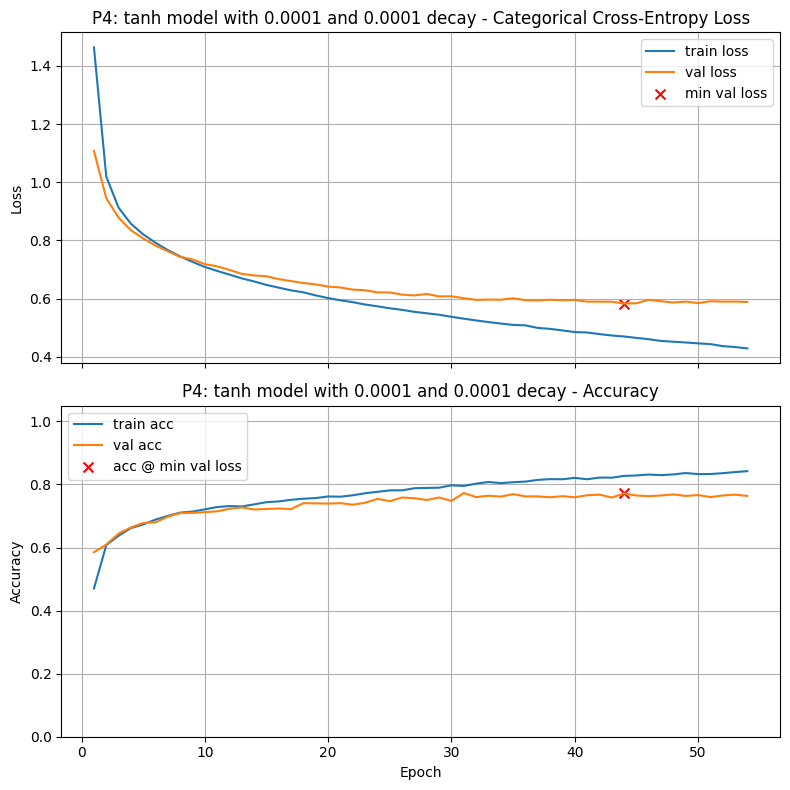

Final Training Loss:            0.4292
Final Training Accuracy:        0.8421
Final Validation Loss:          0.5887
Final Validation Accuracy:      0.7636
Minimum Validation Loss:        0.5830 (Epoch 44)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.6107
Test Accuracy: 0.7593

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:03

P4: tanh model with 0.0001 and 0.001 decay



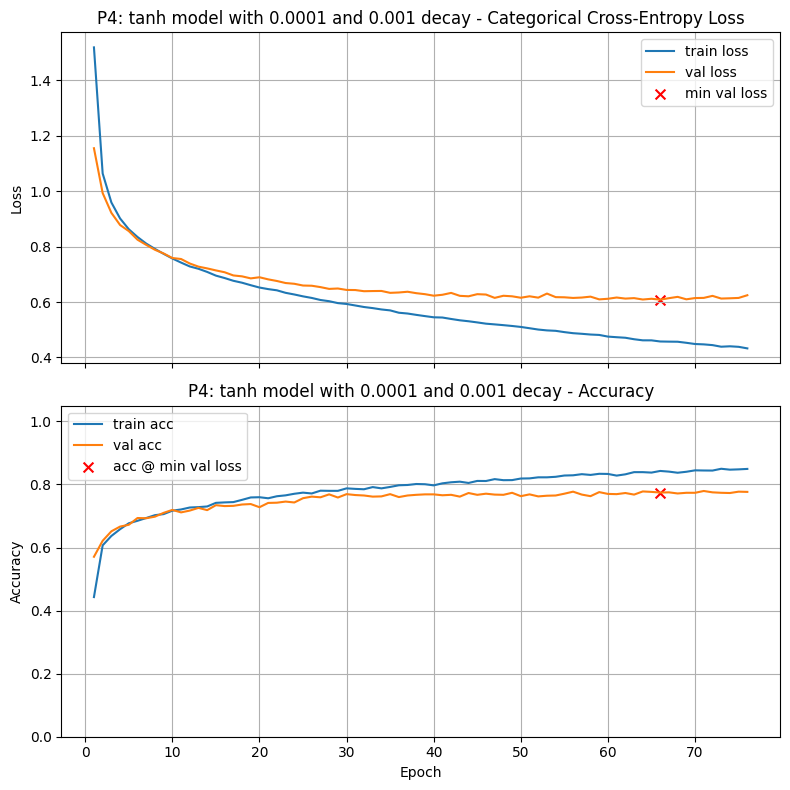

Final Training Loss:            0.4327
Final Training Accuracy:        0.8493
Final Validation Loss:          0.6246
Final Validation Accuracy:      0.7764
Minimum Validation Loss:        0.6087 (Epoch 66)
Validation Accuracy @ Min Loss: 0.7743

Test Loss: 0.6372
Test Accuracy: 0.7536

Validation-Test Gap (accuracy): 0.020714

Execution Time: 00:00:04

P4: tanh model with 0.0001 and 0.01 decay



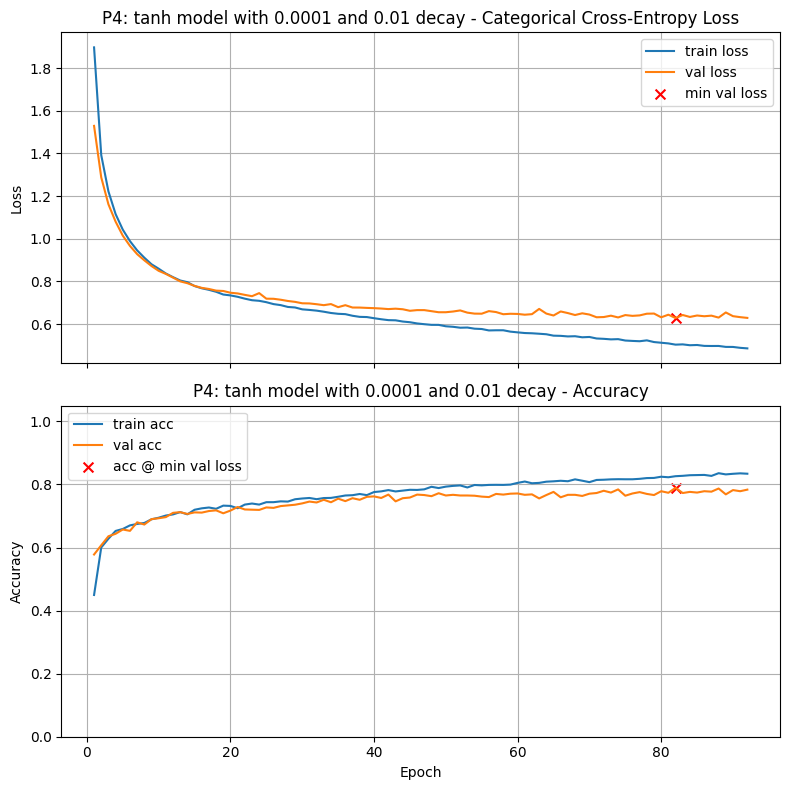

Final Training Loss:            0.4862
Final Training Accuracy:        0.8340
Final Validation Loss:          0.6292
Final Validation Accuracy:      0.7836
Minimum Validation Loss:        0.6286 (Epoch 82)
Validation Accuracy @ Min Loss: 0.7893

Test Loss: 0.6402
Test Accuracy: 0.7571

Validation-Test Gap (accuracy): 0.032143

Execution Time: 00:00:04

P4: tanh model with 0.001 and 0.0001 decay



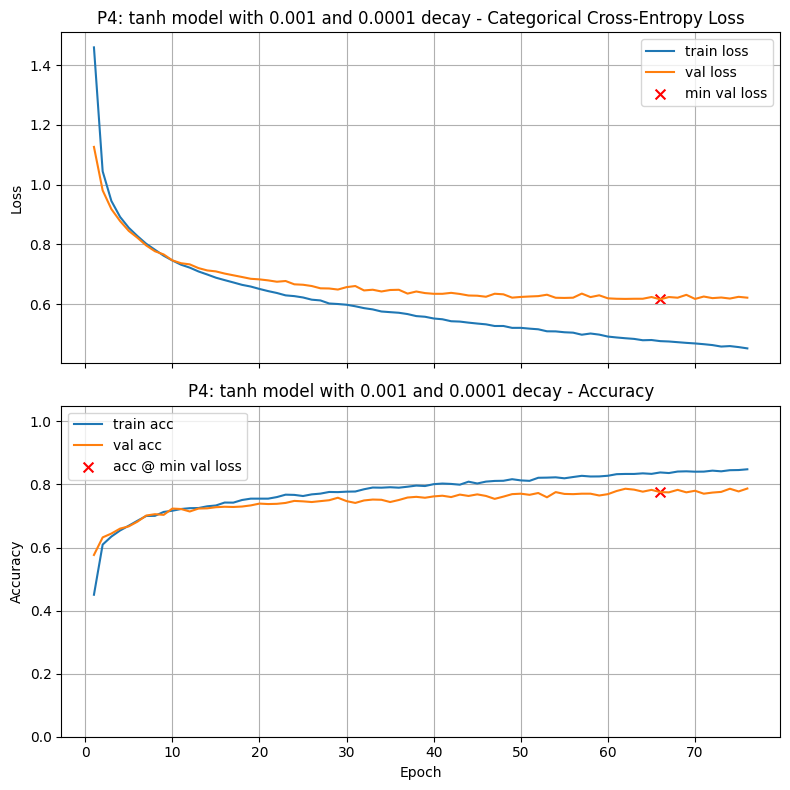

Final Training Loss:            0.4517
Final Training Accuracy:        0.8481
Final Validation Loss:          0.6215
Final Validation Accuracy:      0.7871
Minimum Validation Loss:        0.6160 (Epoch 66)
Validation Accuracy @ Min Loss: 0.7757

Test Loss: 0.6320
Test Accuracy: 0.7586

Validation-Test Gap (accuracy): 0.017143

Execution Time: 00:00:04

P4: tanh model with 0.001 and 0.001 decay



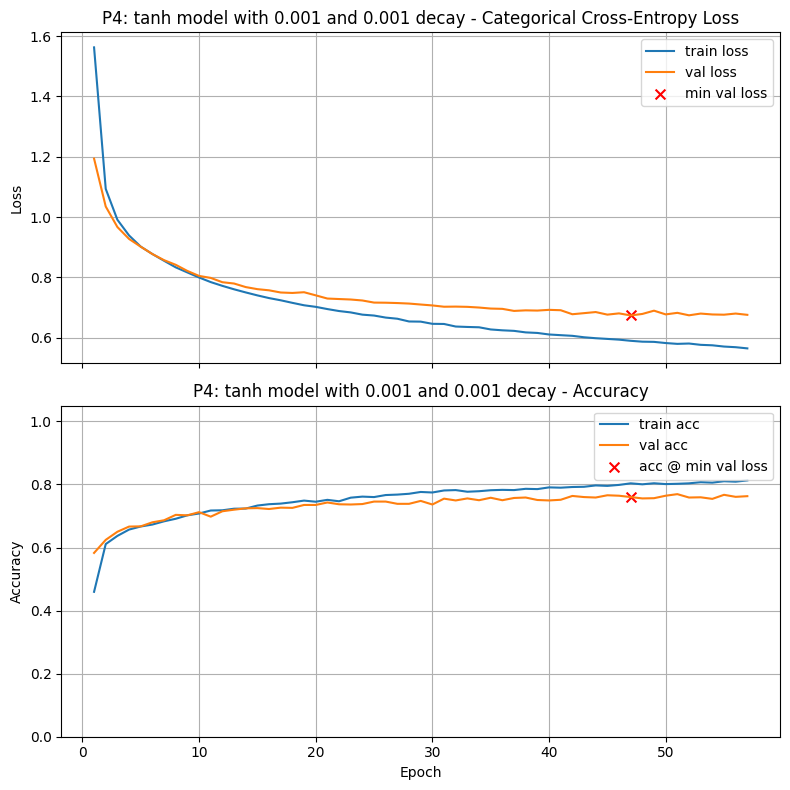

Final Training Loss:            0.5648
Final Training Accuracy:        0.8129
Final Validation Loss:          0.6761
Final Validation Accuracy:      0.7629
Minimum Validation Loss:        0.6741 (Epoch 47)
Validation Accuracy @ Min Loss: 0.7600

Test Loss: 0.6888
Test Accuracy: 0.7429

Validation-Test Gap (accuracy): 0.017143

Execution Time: 00:00:03

P4: tanh model with 0.001 and 0.01 decay



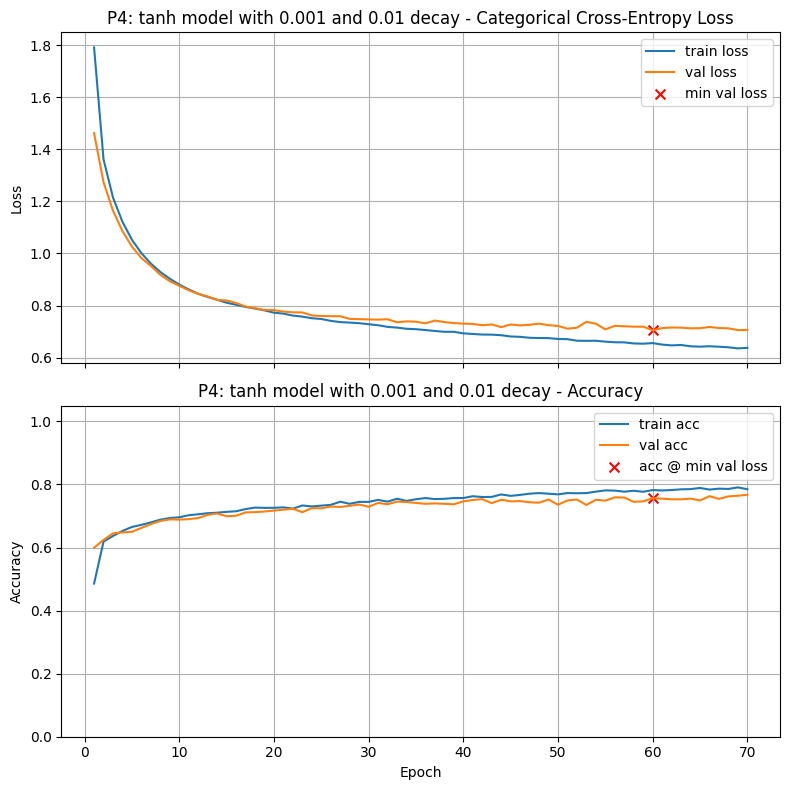

Final Training Loss:            0.6374
Final Training Accuracy:        0.7850
Final Validation Loss:          0.7064
Final Validation Accuracy:      0.7671
Minimum Validation Loss:        0.7047 (Epoch 60)
Validation Accuracy @ Min Loss: 0.7564

Test Loss: 0.7212
Test Accuracy: 0.7436

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:00:03

P4: tanh model with 0.01 and 0.0001 decay



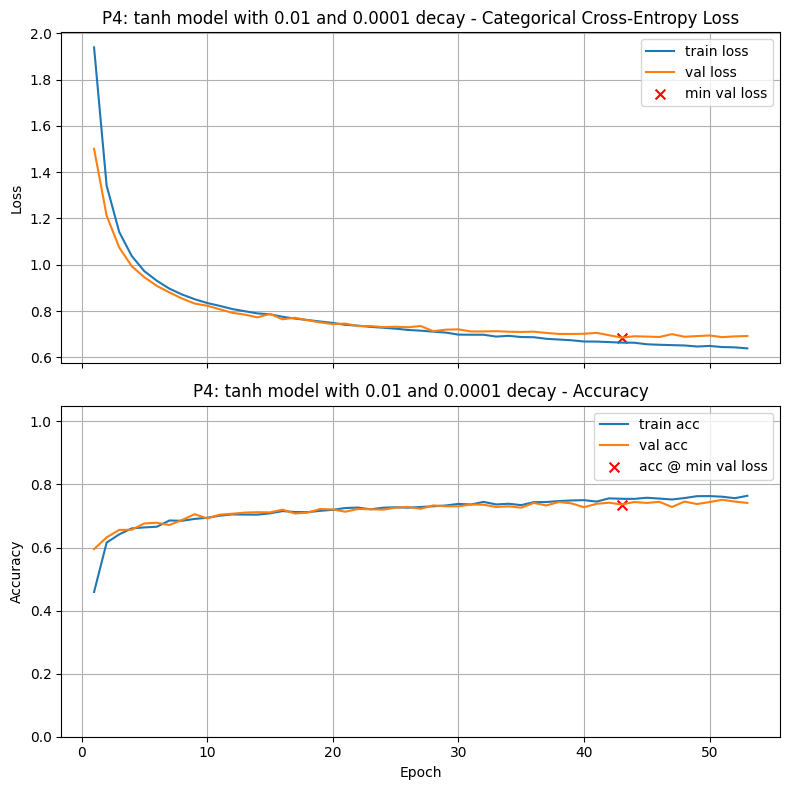

Final Training Loss:            0.6391
Final Training Accuracy:        0.7640
Final Validation Loss:          0.6926
Final Validation Accuracy:      0.7414
Minimum Validation Loss:        0.6857 (Epoch 43)
Validation Accuracy @ Min Loss: 0.7364

Test Loss: 0.7100
Test Accuracy: 0.7307

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:00:03

P4: tanh model with 0.01 and 0.001 decay



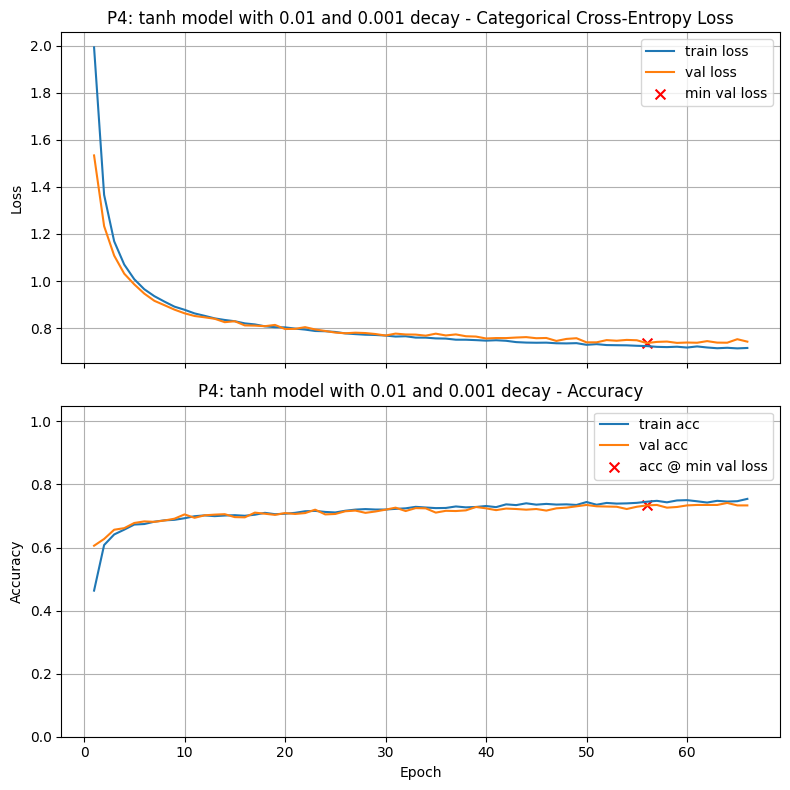

Final Training Loss:            0.7158
Final Training Accuracy:        0.7543
Final Validation Loss:          0.7426
Final Validation Accuracy:      0.7336
Minimum Validation Loss:        0.7367 (Epoch 56)
Validation Accuracy @ Min Loss: 0.7336

Test Loss: 0.7647
Test Accuracy: 0.7221

Validation-Test Gap (accuracy): 0.011429

Execution Time: 00:00:03

P4: tanh model with 0.01 and 0.01 decay



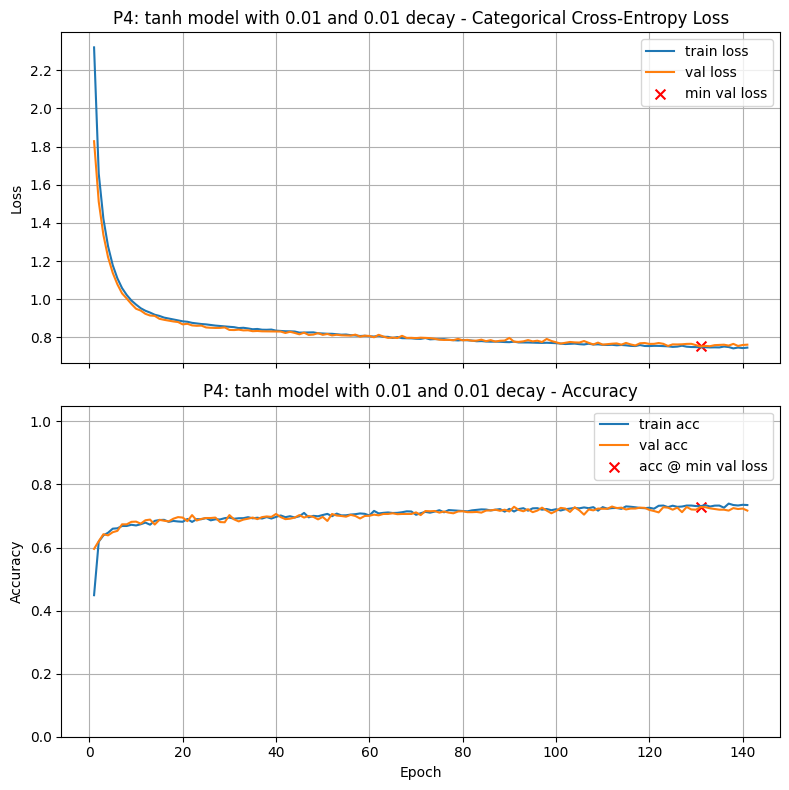

Final Training Loss:            0.7463
Final Training Accuracy:        0.7348
Final Validation Loss:          0.7617
Final Validation Accuracy:      0.7171
Minimum Validation Loss:        0.7524 (Epoch 131)
Validation Accuracy @ Min Loss: 0.7286

Test Loss: 0.7855
Test Accuracy: 0.7221

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:00:06
P2: tanh model with 0.001 learning rate 	0.7936
P4: tanh model with 0.0001 and 0.01 decay	0.7893
P1: tanh model                          	0.7836
P3: tanh model with 0.1 and 0.5 dropout 	0.7793
P3: tanh model with 0.2 and 0.3 dropout 	0.7786
P3: tanh model with 0.1 and 0.4 dropout 	0.7779
P3: tanh model with 0.2 and 0.5 dropout 	0.7757
P4: tanh model with 0.001 and 0.0001 decay	0.7757
P4: tanh model with 0.0001 and 0.001 decay	0.7743
P1: sigmoid model                       	0.7721
P2: tanh model with 0.0001 learning rate	0.7714
P4: tanh model with 0.0001 and 0.0001 decay	0.7714
P3: tanh model with 0.2 and 0.4 dropout 	0.7707
P1: relu mode

In [23]:
# Your code here. Add as many cells as you need. 
weight_decays = [1e-4, 1e-3, 1e-2]
for first_layer_decay in weight_decays:
    for second_layer_decay in weight_decays:
        model_with_L2 = build_model(X_train.shape[1], [ (64,'tanh',first_layer_decay,0.0), (32,'tanh',second_layer_decay,0.0) ], n_classes)
        train_and_test(model_with_L2, lr_schedule=0.001, title=f"P4: tanh model with {first_layer_decay} and {second_layer_decay} decay")

print_results()

In [24]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a4a = (0.0001,0.01)             # Replace (0.0,0.0) with your answer

In [25]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a}') 

a4a = (0.0001, 0.01)


In [27]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = results.get("P4: tanh model with 0.0001 and 0.01 decay")[0]             # Replace 0.0 with your answer

In [28]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.7893


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari 
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.




P5: fixed dropout with 0.0001 and 0.0001 decay



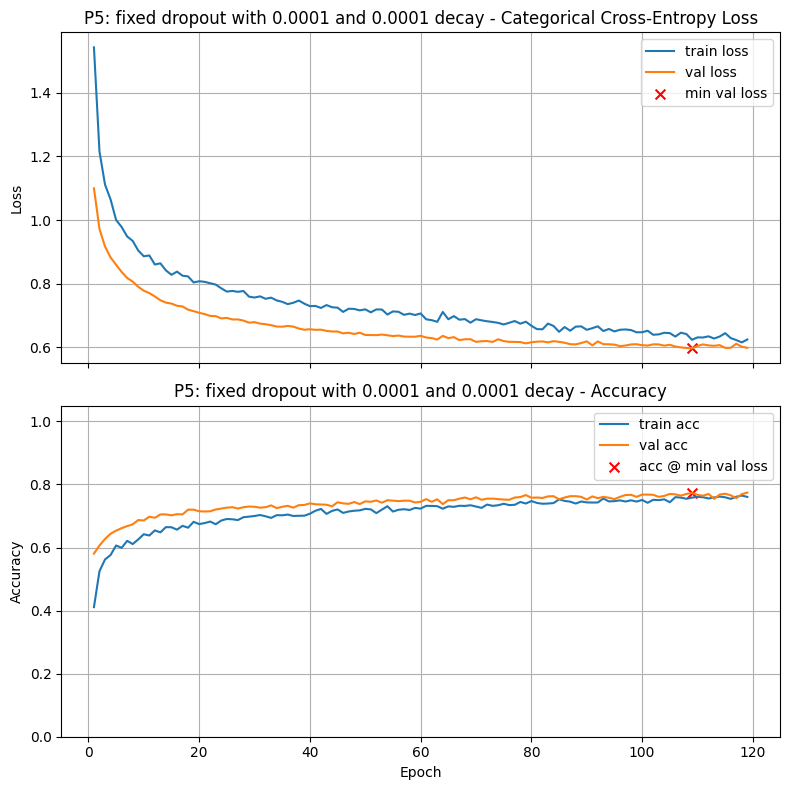

Final Training Loss:            0.6242
Final Training Accuracy:        0.7605
Final Validation Loss:          0.5979
Final Validation Accuracy:      0.7743
Minimum Validation Loss:        0.5962 (Epoch 109)
Validation Accuracy @ Min Loss: 0.7729

Test Loss: 0.6349
Test Accuracy: 0.7586

Validation-Test Gap (accuracy): 0.014286

Execution Time: 00:00:06

P5: fixed dropout with 0.0001 and 0.001 decay



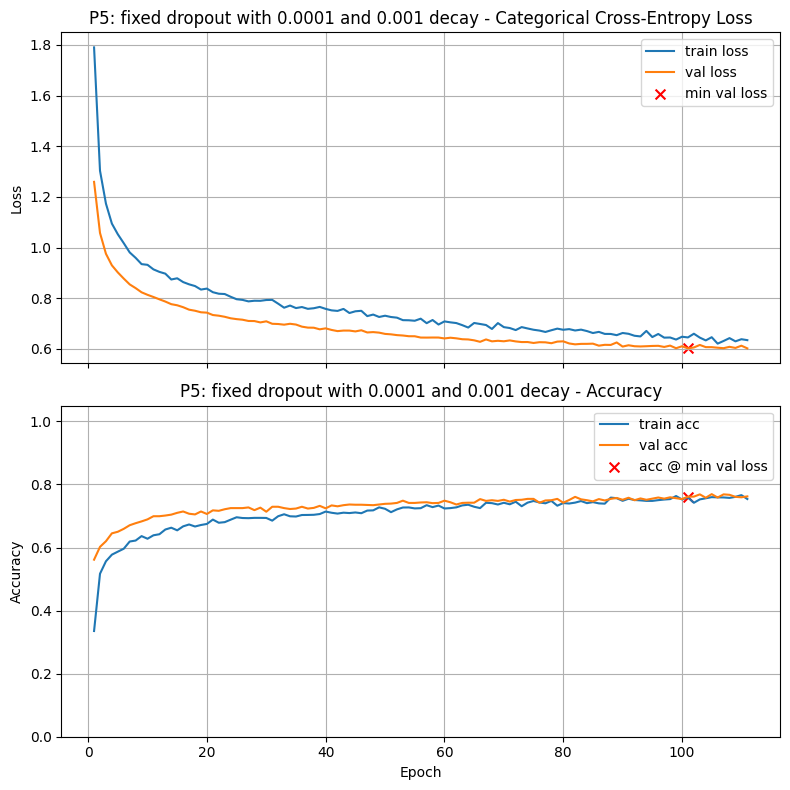

Final Training Loss:            0.6345
Final Training Accuracy:        0.7538
Final Validation Loss:          0.6021
Final Validation Accuracy:      0.7621
Minimum Validation Loss:        0.6020 (Epoch 101)
Validation Accuracy @ Min Loss: 0.7614

Test Loss: 0.6453
Test Accuracy: 0.7450

Validation-Test Gap (accuracy): 0.016429

Execution Time: 00:00:05

P5: fixed dropout with 0.0001 and 0.01 decay



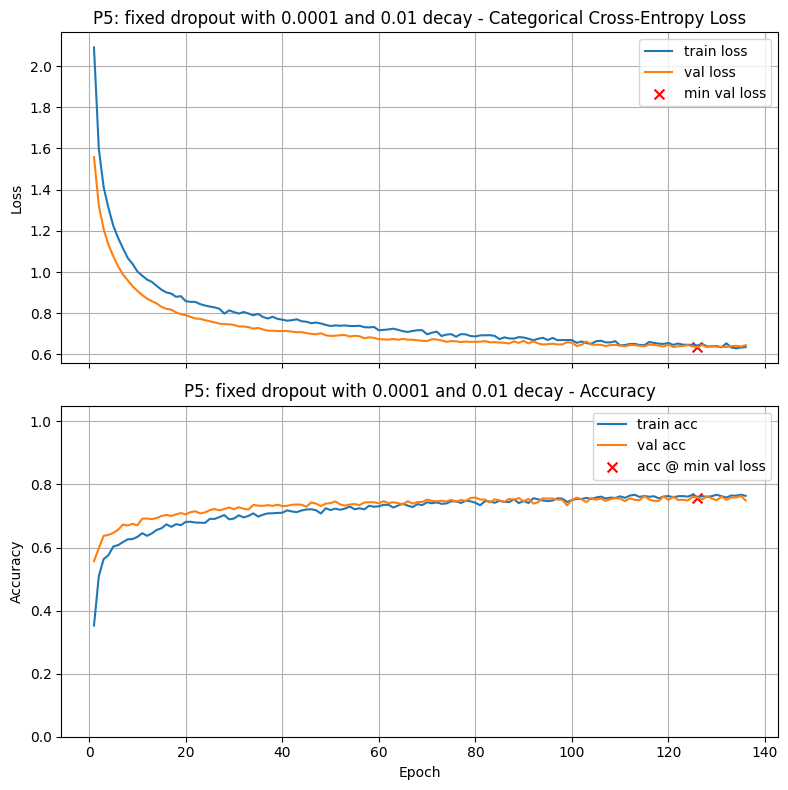

Final Training Loss:            0.6355
Final Training Accuracy:        0.7638
Final Validation Loss:          0.6449
Final Validation Accuracy:      0.7493
Minimum Validation Loss:        0.6354 (Epoch 126)
Validation Accuracy @ Min Loss: 0.7586

Test Loss: 0.6596
Test Accuracy: 0.7529

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:00:07

P5: fixed dropout with 0.001 and 0.0001 decay



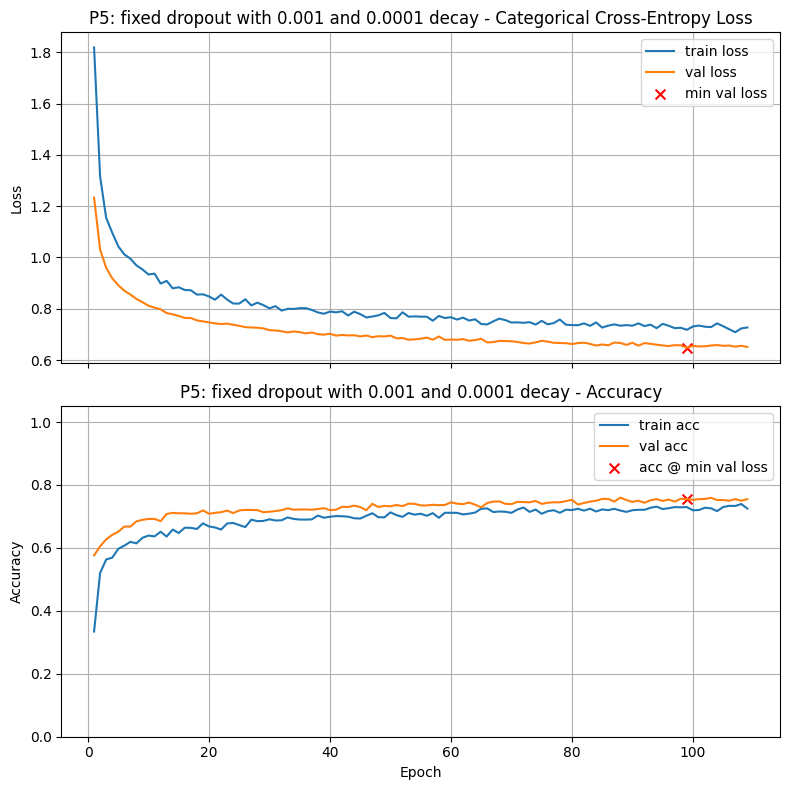

Final Training Loss:            0.7272
Final Training Accuracy:        0.7252
Final Validation Loss:          0.6512
Final Validation Accuracy:      0.7550
Minimum Validation Loss:        0.6482 (Epoch 99)
Validation Accuracy @ Min Loss: 0.7550

Test Loss: 0.6925
Test Accuracy: 0.7386

Validation-Test Gap (accuracy): 0.016429

Execution Time: 00:00:05

P5: fixed dropout with 0.001 and 0.001 decay



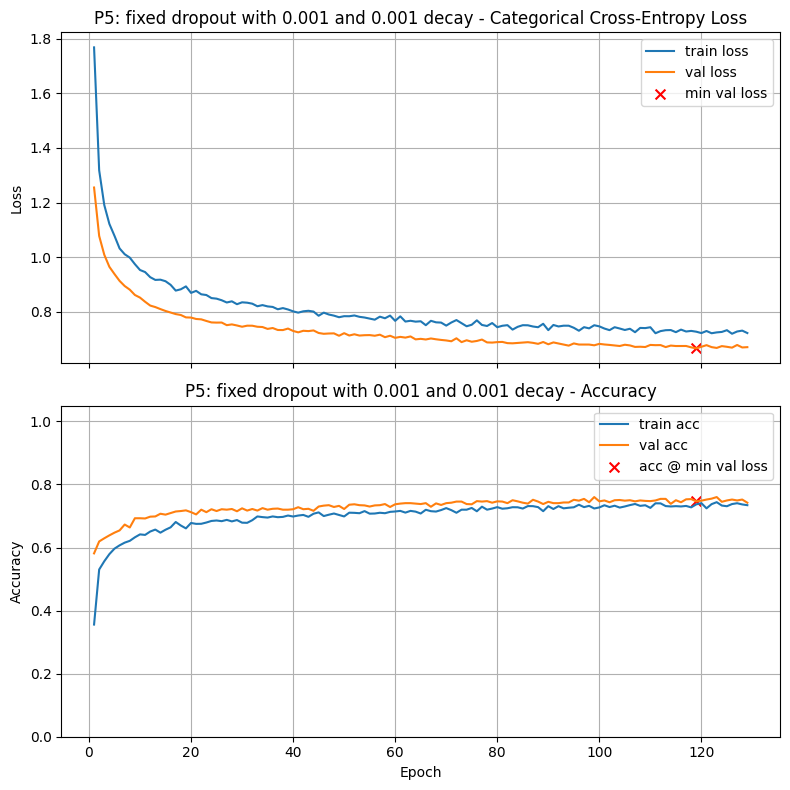

Final Training Loss:            0.7231
Final Training Accuracy:        0.7343
Final Validation Loss:          0.6715
Final Validation Accuracy:      0.7421
Minimum Validation Loss:        0.6670 (Epoch 119)
Validation Accuracy @ Min Loss: 0.7464

Test Loss: 0.6959
Test Accuracy: 0.7586

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:06

P5: fixed dropout with 0.001 and 0.01 decay



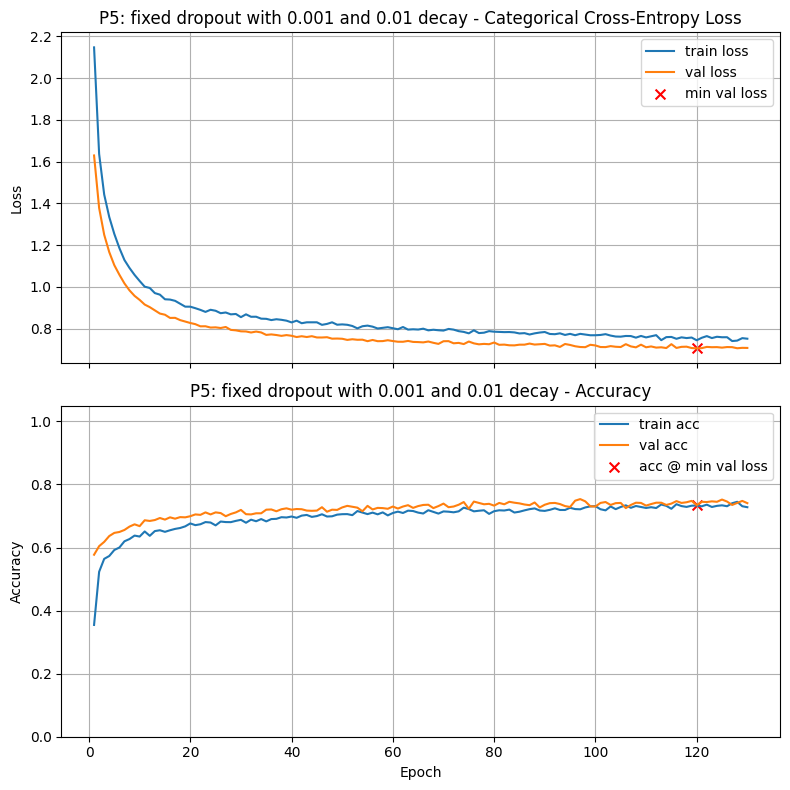

Final Training Loss:            0.7525
Final Training Accuracy:        0.7279
Final Validation Loss:          0.7084
Final Validation Accuracy:      0.7407
Minimum Validation Loss:        0.7062 (Epoch 120)
Validation Accuracy @ Min Loss: 0.7343

Test Loss: 0.7377
Test Accuracy: 0.7279

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:00:06

P5: fixed dropout with 0.01 and 0.0001 decay



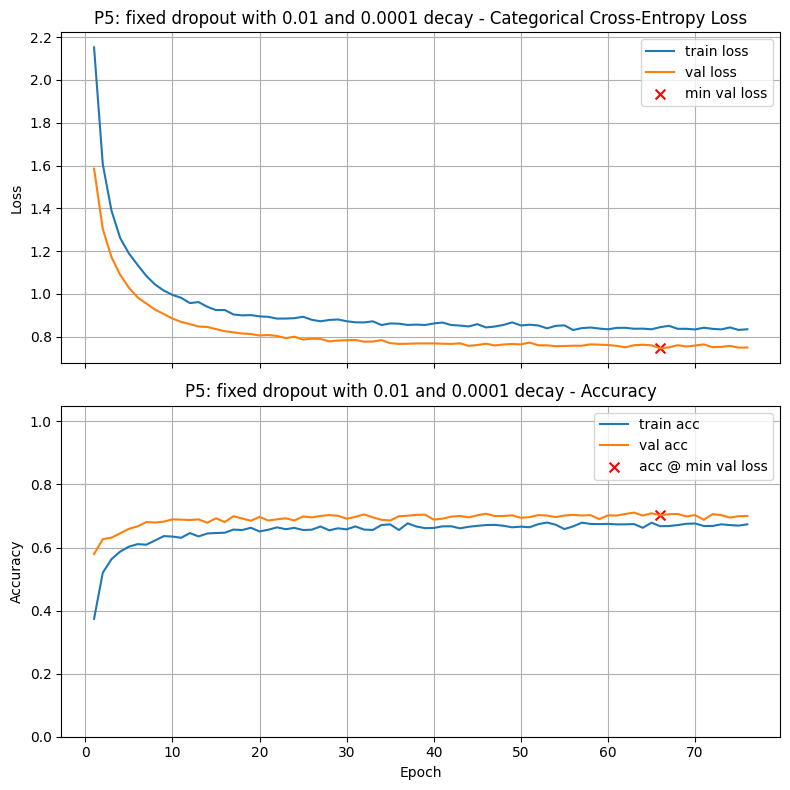

Final Training Loss:            0.8346
Final Training Accuracy:        0.6736
Final Validation Loss:          0.7492
Final Validation Accuracy:      0.7000
Minimum Validation Loss:        0.7452 (Epoch 66)
Validation Accuracy @ Min Loss: 0.7021

Test Loss: 0.7718
Test Accuracy: 0.6929

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:04

P5: fixed dropout with 0.01 and 0.001 decay



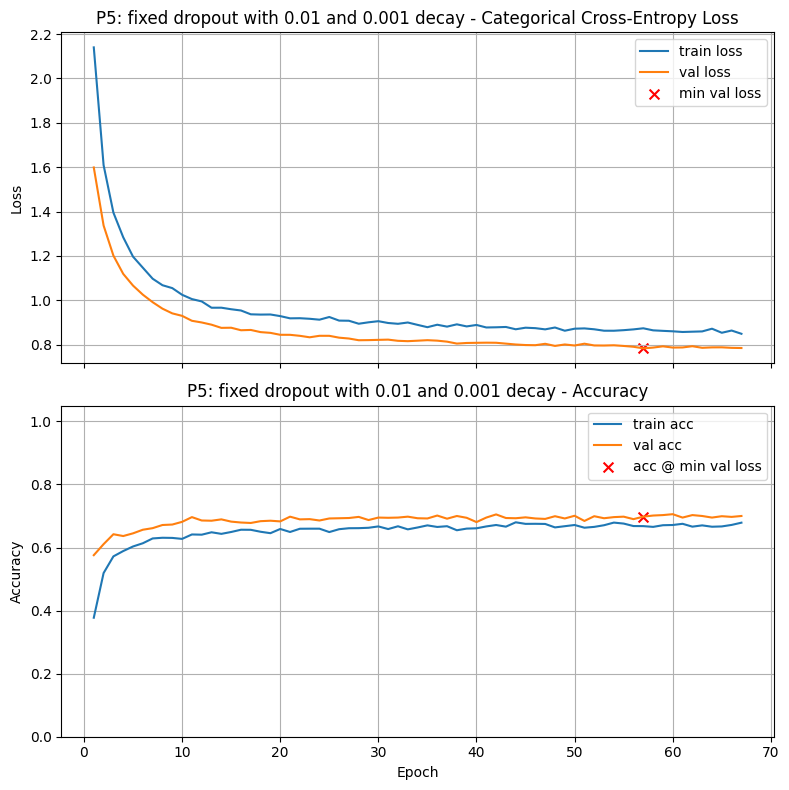

Final Training Loss:            0.8493
Final Training Accuracy:        0.6788
Final Validation Loss:          0.7851
Final Validation Accuracy:      0.7000
Minimum Validation Loss:        0.7835 (Epoch 57)
Validation Accuracy @ Min Loss: 0.6979

Test Loss: 0.8168
Test Accuracy: 0.6886

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:03

P5: fixed dropout with 0.01 and 0.01 decay



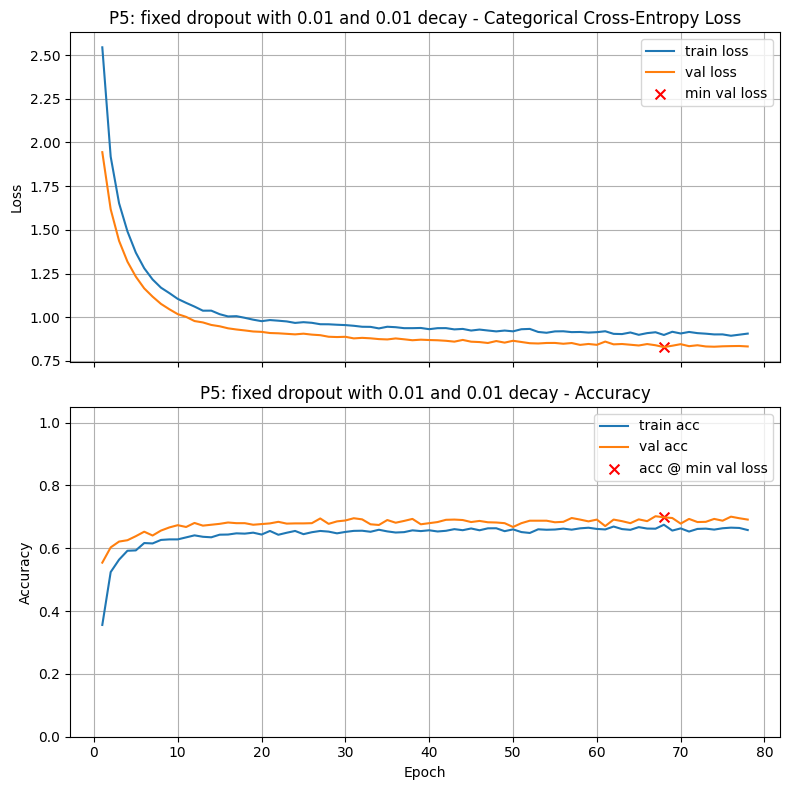

Final Training Loss:            0.9066
Final Training Accuracy:        0.6581
Final Validation Loss:          0.8330
Final Validation Accuracy:      0.6914
Minimum Validation Loss:        0.8294 (Epoch 68)
Validation Accuracy @ Min Loss: 0.6986

Test Loss: 0.8531
Test Accuracy: 0.6900

Validation-Test Gap (accuracy): 0.008571

Execution Time: 00:00:04
P2: tanh model with 0.001 learning rate 	0.7936
P4: tanh model with 0.0001 and 0.01 decay	0.7893
P1: tanh model                          	0.7836
P3: tanh model with 0.1 and 0.5 dropout 	0.7793
P3: tanh model with 0.2 and 0.3 dropout 	0.7786
P3: tanh model with 0.1 and 0.4 dropout 	0.7779
P3: tanh model with 0.2 and 0.5 dropout 	0.7757
P4: tanh model with 0.001 and 0.0001 decay	0.7757
P4: tanh model with 0.0001 and 0.001 decay	0.7743
P5: fixed dropout with 0.0001 and 0.0001 decay	0.7729
P1: sigmoid model                       	0.7721
P2: tanh model with 0.0001 learning rate	0.7714
P4: tanh model with 0.0001 and 0.0001 decay	0.7714
P3: tanh

In [29]:
# Your code here. Add as many cells as you need.
first_dropout = 0.1
second_dropout = 0.5 
weight_decays = [1e-4, 1e-3, 1e-2]
for first_layer_decay in weight_decays:
    for second_layer_decay in weight_decays:
        model_with_L2_and_dropout = build_model(X_train.shape[1], [ (64,'tanh',first_layer_decay,first_dropout), (32,'tanh',second_layer_decay,second_dropout) ], n_classes)
        train_and_test(model_with_L2_and_dropout, lr_schedule=0.001, title=f"P5: fixed dropout with {first_layer_decay} and {second_layer_decay} decay")

print_results()


P5: reduced dropout with 0.0001 and 0.0001 decay



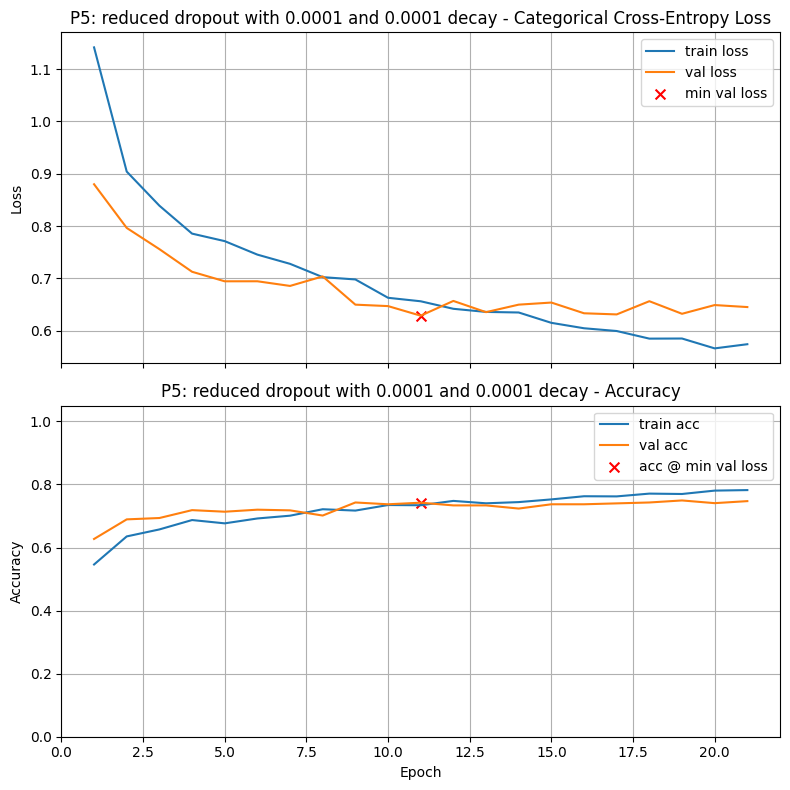

Final Training Loss:            0.5744
Final Training Accuracy:        0.7821
Final Validation Loss:          0.6454
Final Validation Accuracy:      0.7471
Minimum Validation Loss:        0.6289 (Epoch 11)
Validation Accuracy @ Min Loss: 0.7421

Test Loss: 0.6639
Test Accuracy: 0.7293

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:00:01

P5: reduced dropout with 0.0001 and 0.001 decay



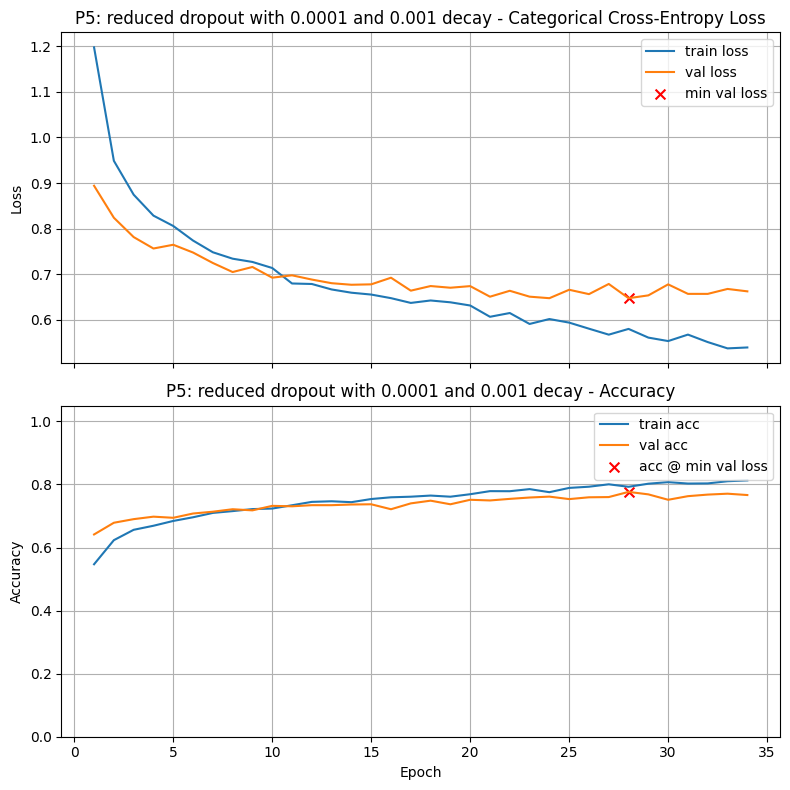

Final Training Loss:            0.5391
Final Training Accuracy:        0.8129
Final Validation Loss:          0.6623
Final Validation Accuracy:      0.7664
Minimum Validation Loss:        0.6472 (Epoch 28)
Validation Accuracy @ Min Loss: 0.7764

Test Loss: 0.6658
Test Accuracy: 0.7521

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:02

P5: reduced dropout with 0.0001 and 0.01 decay



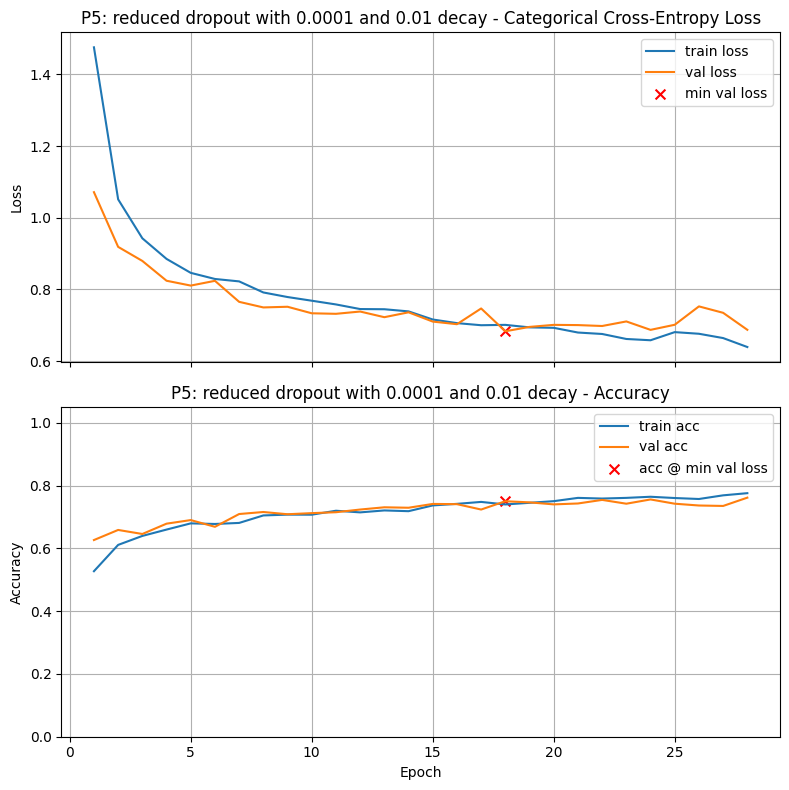

Final Training Loss:            0.6392
Final Training Accuracy:        0.7757
Final Validation Loss:          0.6873
Final Validation Accuracy:      0.7614
Minimum Validation Loss:        0.6832 (Epoch 18)
Validation Accuracy @ Min Loss: 0.7500

Test Loss: 0.7179
Test Accuracy: 0.7221

Validation-Test Gap (accuracy): 0.027857

Execution Time: 00:00:02

P5: reduced dropout with 0.001 and 0.0001 decay



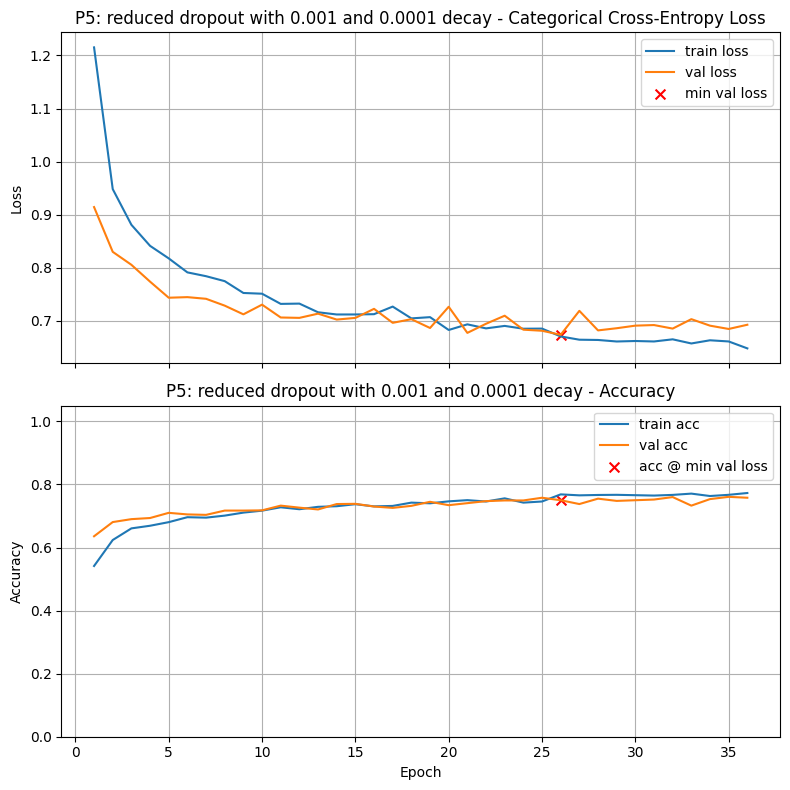

Final Training Loss:            0.6484
Final Training Accuracy:        0.7729
Final Validation Loss:          0.6929
Final Validation Accuracy:      0.7579
Minimum Validation Loss:        0.6739 (Epoch 26)
Validation Accuracy @ Min Loss: 0.7500

Test Loss: 0.6952
Test Accuracy: 0.7450

Validation-Test Gap (accuracy): 0.005000

Execution Time: 00:00:02

P5: reduced dropout with 0.001 and 0.001 decay



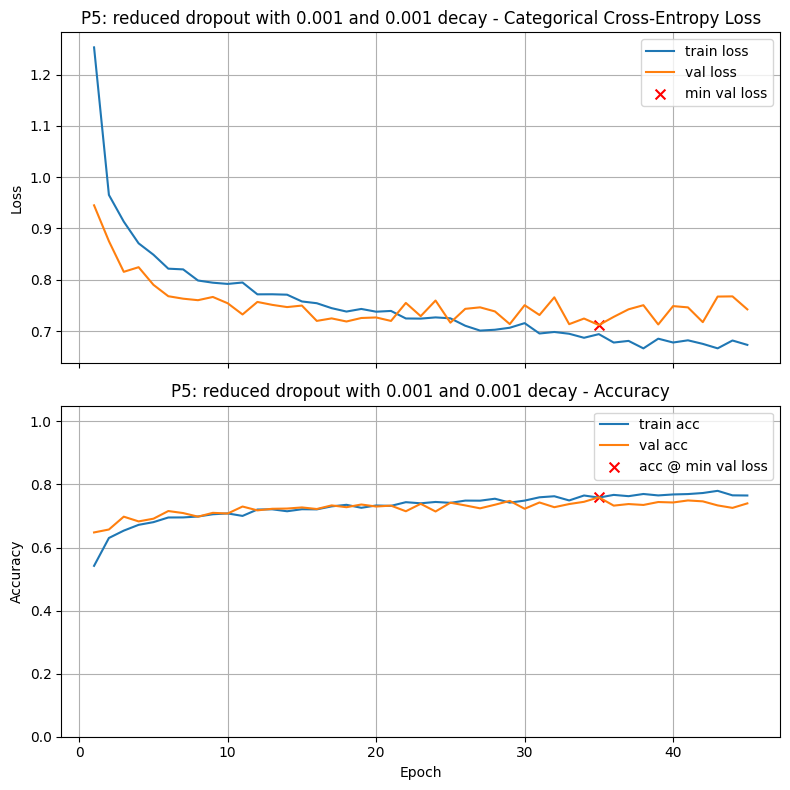

Final Training Loss:            0.6731
Final Training Accuracy:        0.7650
Final Validation Loss:          0.7424
Final Validation Accuracy:      0.7400
Minimum Validation Loss:        0.7118 (Epoch 35)
Validation Accuracy @ Min Loss: 0.7593

Test Loss: 0.7414
Test Accuracy: 0.7414

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:02

P5: reduced dropout with 0.001 and 0.01 decay



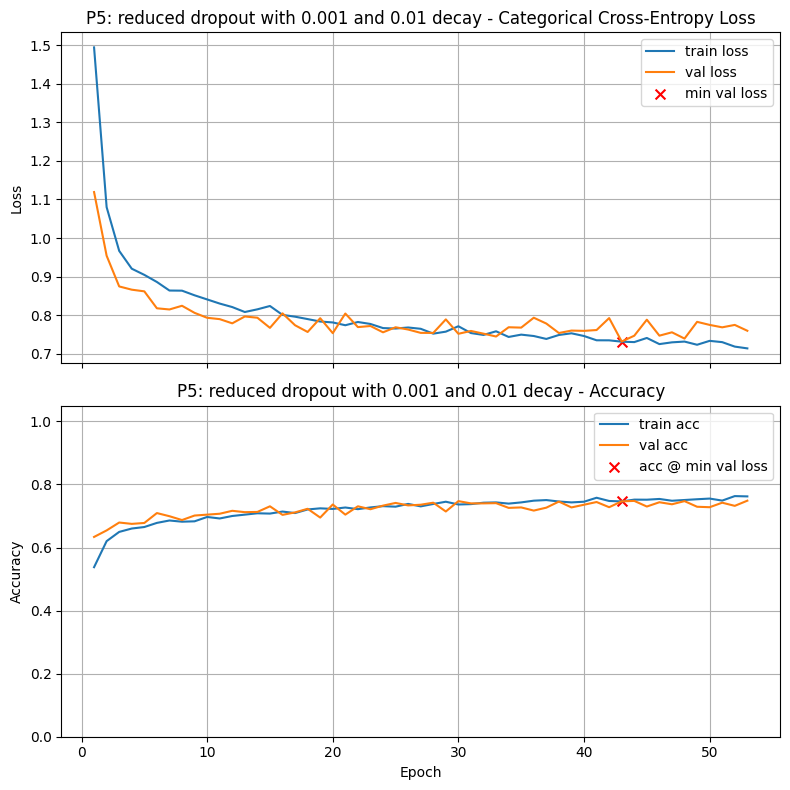

Final Training Loss:            0.7138
Final Training Accuracy:        0.7621
Final Validation Loss:          0.7595
Final Validation Accuracy:      0.7486
Minimum Validation Loss:        0.7315 (Epoch 43)
Validation Accuracy @ Min Loss: 0.7464

Test Loss: 0.7684
Test Accuracy: 0.7393

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:03

P5: reduced dropout with 0.01 and 0.0001 decay



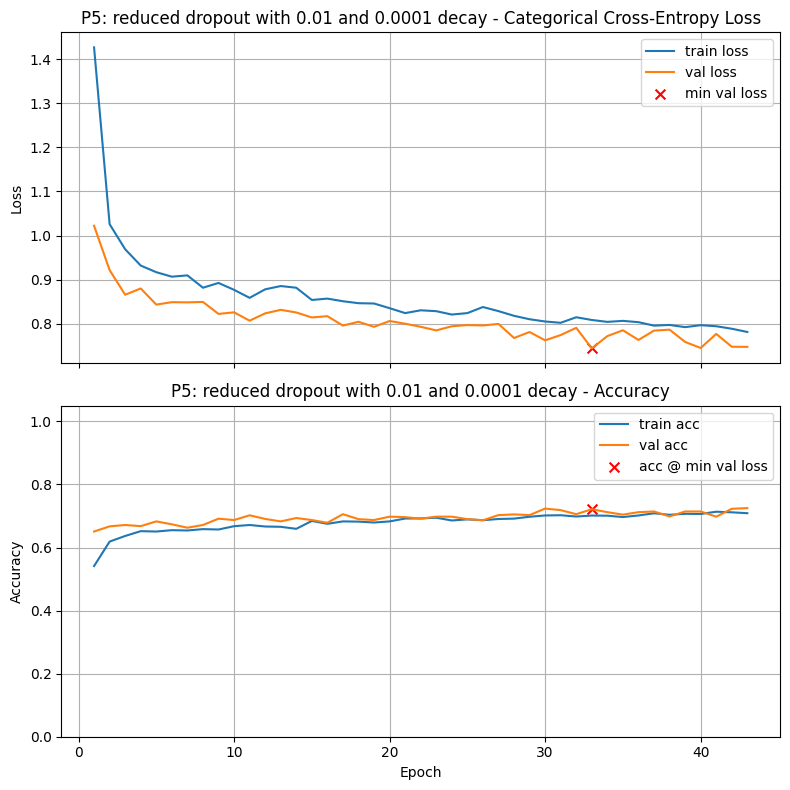

Final Training Loss:            0.7813
Final Training Accuracy:        0.7088
Final Validation Loss:          0.7475
Final Validation Accuracy:      0.7250
Minimum Validation Loss:        0.7441 (Epoch 33)
Validation Accuracy @ Min Loss: 0.7214

Test Loss: 0.7793
Test Accuracy: 0.7136

Validation-Test Gap (accuracy): 0.007857

Execution Time: 00:00:02

P5: reduced dropout with 0.01 and 0.001 decay



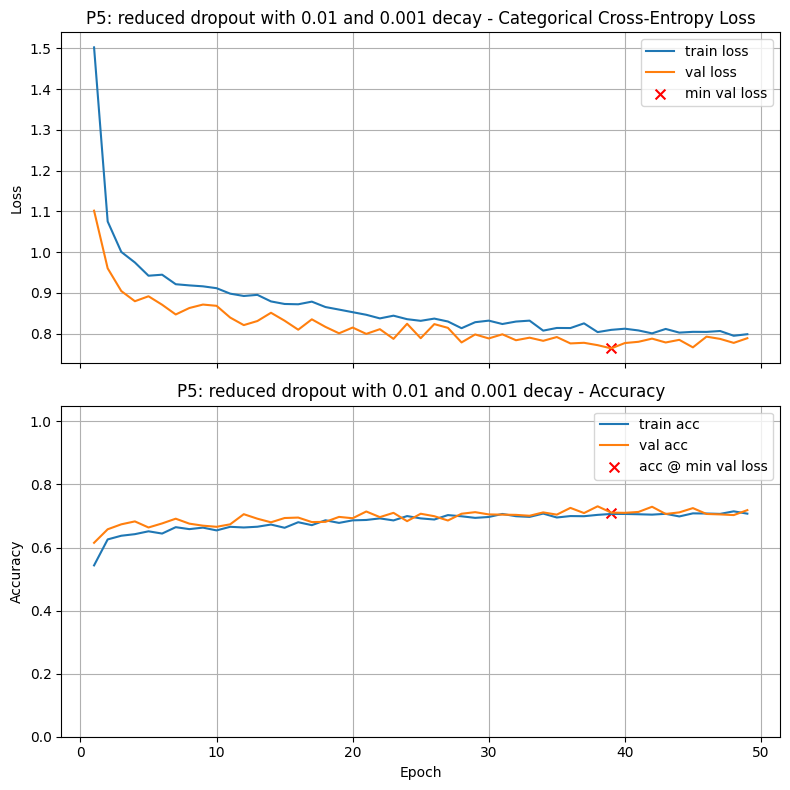

Final Training Loss:            0.7989
Final Training Accuracy:        0.7074
Final Validation Loss:          0.7891
Final Validation Accuracy:      0.7186
Minimum Validation Loss:        0.7641 (Epoch 39)
Validation Accuracy @ Min Loss: 0.7107

Test Loss: 0.8038
Test Accuracy: 0.6986

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:02

P5: reduced dropout with 0.01 and 0.01 decay



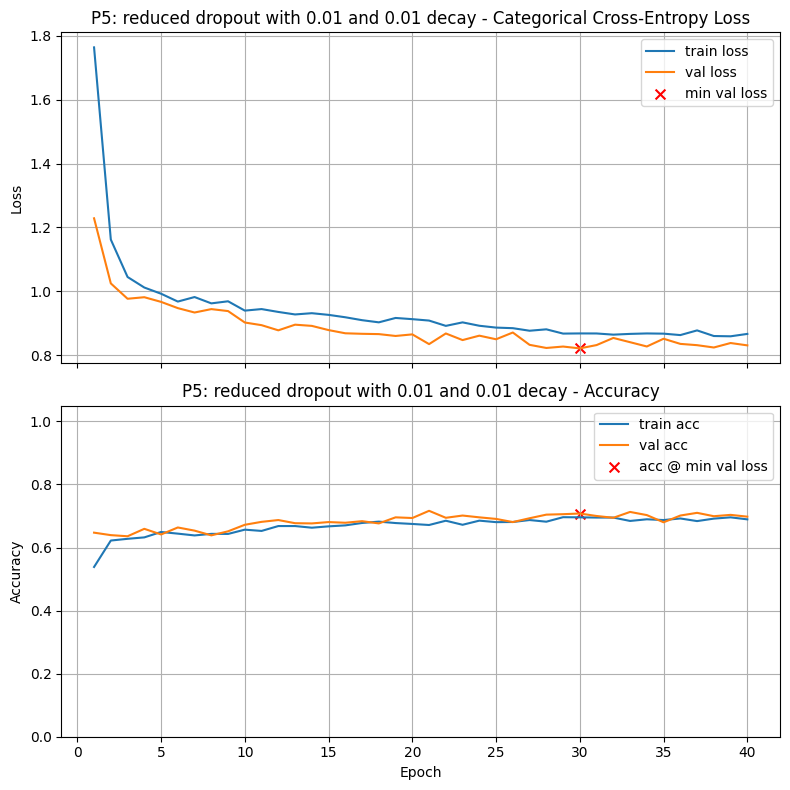

Final Training Loss:            0.8667
Final Training Accuracy:        0.6893
Final Validation Loss:          0.8308
Final Validation Accuracy:      0.6979
Minimum Validation Loss:        0.8214 (Epoch 30)
Validation Accuracy @ Min Loss: 0.7079

Test Loss: 0.8705
Test Accuracy: 0.6871

Validation-Test Gap (accuracy): 0.020714

Execution Time: 00:00:02
P2: tanh model with 0.001 learning rate 	0.7936
P4: tanh model with 0.0001 and 0.01 decay	0.7893
P1: tanh model                          	0.7836
P3: tanh model with 0.1 and 0.5 dropout 	0.7793
P3: tanh model with 0.2 and 0.3 dropout 	0.7786
P3: tanh model with 0.1 and 0.4 dropout 	0.7779
P5: reduced dropout with 0.0001 and 0.001 decay	0.7764
P3: tanh model with 0.2 and 0.5 dropout 	0.7757
P4: tanh model with 0.001 and 0.0001 decay	0.7757
P4: tanh model with 0.0001 and 0.001 decay	0.7743
P5: fixed dropout with 0.0001 and 0.0001 decay	0.7729
P1: sigmoid model                       	0.7721
P2: tanh model with 0.0001 learning rate	0.7714
P4: 

In [30]:
first_dropout = 0.0
second_dropout = 0.3 
weight_decays = [1e-4, 1e-3, 1e-2]
for first_layer_decay in weight_decays:
    for second_layer_decay in weight_decays:
        model_with_L2_and_dropout = build_model(X_train.shape[1], [ (64,'tanh',first_layer_decay,first_dropout), (32,'tanh',second_layer_decay,second_dropout) ], n_classes)
        train_and_test(model_with_L2_and_dropout, lr_schedule=0.005, title=f"P5: reduced dropout with {first_layer_decay} and {second_layer_decay} decay")

print_results()

In [31]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = results.get("P5: reduced dropout with 0.0001 and 0.001 decay")[0]  # Replace 0.0 with your answer

In [32]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5 = {a5:.4f}') 

a5 = 0.7764


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.


In [ ]:
# Your code here


In [ ]:
# Set a6 to the validation accuracy found by this best model

a6 = 0.0             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a6 = {a6:.4f}') 

### Optional: Print out your results of all experiments

In [ ]:
print_results()

## Reflection Questions (ungraded)

It would be a great idea to think through your answers to these questions, then give ChatGPT (or other AI tool) a PDF of your
homework, and **discuss** (not just ask) these. 

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
    
    - How might this choice differ for deeper or wider networks?

2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
    
    - When is it worth training longer with a smaller step size, and when is it unnecessary?

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
    
    - Why might one method be more effective in this setting?

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
    
    - What does this tell you about the balance between bias and variance in regularization?

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?
    
    - Did learning rate scheduling (if you tried it) improve results? Why might it help?